In [3]:
%matplotlib inline
import deepdish as dd
import h5py
import numpy as np
from galaxy_analysis.plot.plot_styles import *
import matplotlib.pyplot as plt
from galaxy_analysis.utilities import utilities
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from galaxy_analysis.utilities import convert_abundances

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import glob
import os, sys


def plot_settings():
    fsize = 21
    rc('text',usetex=False)
    rc('font',size=fsize)
    return

plot_settings()

from matplotlib.text import TextPath

yr_s = 3.154E7



#sys.stdout = TracePrints()

In [2]:
def dlist_asarray(dict_list, key_list, as_list = False):
    
    res = [None]*len(dict_list)
    #print(len(dict_list))
    
    for i,d in enumerate(dict_list):
        res[i] = extract_nested_dict(d, key_list)
        
    if as_list:
        return res
    
    return np.array(res)
 

    
def extract_nested_dict(dict, key_list):
    """
    Given a list of kwargs, extracts the information requested
    from a nested dictionary
    """
    x = dict

    if isinstance(key_list, str) or isinstance(key_list, tuple):
        x = x[key_list]
    elif isinstance(key_list, list):
        for k in key_list:
            x = x[k]

    return x


    
#def extract_nested_dict(d, key_list):
#    
#    if isinstance(key_list, str):
#        return d[key_list]
#    elif len(key_list) == 1:
#        try:
#            return d[key_list[0]]
##        except:
 #           print(key_list)
#            print(key_list[0])
#            print(d)
#            raise ValueError
#    
#    return extract_nested_dict( d[key_list[0]], key_list[1:])

class DataContainer:
    
    def __init__(self, directory, file_list = None, self_contained = False,
                 name = None, data_file_name = "*_galaxy_data.h5"):
        
        self.directory = directory
        
        self.self_contained = self_contained # sets if the "file list" is a list
                                             # files to be loaded (False) or 
                                             # a list of data dump names (True)
                                             # contained within the data_file_name
        
        self.file_list      = file_list
        self.data_file_name = data_file_name

        self._data = {} # stores data
        
        if (self.file_list is None):
            
            if not self.self_contained:
                self.file_list = np.sort(glob.glob(directory + '/' + self.data_file_name))
            else:
                raise NotImplementedError 
      
    
        self.known_paths = {'SFR'  : '/time_data/SFR',
                            'time' : '/meta_data/Time',
                            'meta_data' : '/meta_data',
                           }
        self.load_phase_plots()        
        
        
        if name is None:
            self.name = directory
        else:
            self.name = name
            
        self.load_loading_table()
            
            
        # do some prep
        self.load_field(self.known_paths['time'],label='time',
                        reload=True, to_array=True)
        
        self.t_sf_start = self.data('time')[0]
        self.first_DD   = int(self.t_sf_start)
        
        self.load_field(self.known_paths['meta_data'], label='meta_data',
                        reload=True, to_array=False)
                
        # pre-load the easy things
        for k in self._data['meta_data'][0].keys():
            self._data[k] = dlist_asarray( self._data['meta_data'], [k])
    
        return
        
    def data(self, label):
        
        if label in self.loaded_fields():
            return self._data[label]
        
        if label in self.known_paths:
            path = self.known_paths[label]
        
        self.load_field(path, label=label)
        
        return self._data[label]
    
    
    def load_loading_table(self):
        # load (if available) loading table from LiBryan2019 
        
        loading_table = glob.glob( self.directory + '/*loading_table.dat')
        
        if len(loading_table) == 0:
            self.loading_table_values = None
            print("Loading data table not found for ", self.name)
            return
        
        
        keys = ["Eta_mass", "Eta_mass_hot", "Eta_mass_cold", 
                "Eta_metal", "Eta_metal_hot", "Eta_metal_cold", 
                "Eta_E", "Eta_E_hot", "Eta_E_cold", "Eta_E_hot_cold_ratio",
                "e_s", "e_s_hot", "e_s_cold", "e_s_hot_cold_ratio",
                "Sigma_gas", "Sigma_sfr", "Eta_hot_Eta_Metal_hot_ratio"]
        
        self.loading_table_values = {}
        for k in keys:
            self.loading_table_values[k] = -999
            
        with open(loading_table[0]) as fp:
            count = 0
            for line in fp:
                self.loading_table_values[ keys[count] ] = float(line.split(" ")[-1])
                count = count + 1
    
        return
            
    
    def load_single(self, path, filename = None, index = None):
        
        if (filename is None) and (index is None):
            print("Must provide either name of file or index in file_list")
            raise ValueError
            
        if (filename is None):
            filename = self.file_list[index]
            
        if path in self.known_paths.keys(): # assume path = label if true
            path = self.known_paths[path]
                
        
        return dd.io.load(filename, path)
        
        
    def load_field(self, path, label = None, reload = False,
                               to_array    = True):
        """
        Grab data from file given dictionary path. 
        
        path   :  str
            string or list of strings to pass to deepdish
            to selectively load the desired field. 
        label  : str, optional
            optional alias to be used in place of path
            in self.data dictionary. Default: none (set to path)
        reload  : bool, optional
            By default, just returns data in self.data if 
            label exists already. Otherwise reloads and overwrites.
            Default : False
        to_array: bool, optional
            By default, if retrieved data are just single scalars
            it is stored as a numpy array. Otherwise it is kept 
            as a list. Set this to override default behavior
            and keep as list
        """
        
        if (label is None):
            label = path
                          
        if (path is None):
            path = self.known_paths[label]
            
        if not reload:
            if label in self._data.keys():
                return self._data[label]
                
        # else - load
        self._data[label] = [0.0]*np.size(self.file_list)
        fail_count = 0
        for i,filename in enumerate(self.file_list):
                          
            try:
                self._data[label][i] = dd.io.load(filename,path)
            except:
                # may need to do this for backwards compatibility. Some versions
                # have all ('gas','cell_mass') esque fields converted to strings
                # otherers still have it as a tuple. Handle tuples here:
                
                try:
                    last_val  = path.split('/')[-1]
                    str0      = last_val.split(',')[0].strip("'").strip("('")   # get first
                    str1      = last_val.split(',')[1].strip(" '").strip("')")  # get second
                
                    temp_data = dd.io.load(filename, path.strip(last_val))
                    self._data[label][i] = temp_data[(str0,str1)]
                    
                except:
                
                    fail_count += 1
                          
            if fail_count > 10:
                print(self.name)
                print("Failed more than %i times loading with path %s and label %s"%(fail_count, path, label))
                raise RuntimeError
        
        if to_array:
            self._data[label] = np.array(self._data[label])
                          
        return self._data[label]
            
    def load_image(self, time, field, axis, image_type = 'proj'):
        """
        Load (but don't persist) projection data at a given time relative
        to first star formation (already goes and grabs correct corresponding
        data dump). Throws an error if data dump does not exist. Assumes
        projection data is in an HDF5 file that has axis on top level and fields one below
        
        image_type = 'proj' or 'slice'
        """
        #
        # 
        #
        
        dd_num = int(time + self.t_sf_start)
        
        if dd_num < 0:
            print("trying to load a data set before first star formation. Is this really what you want?")
            raise RuntimeError
        
        dsname = "DD%0004i"%(dd_num)
        
        image_str = ''
        if image_type == 'proj':
            image_str = 'Proj'
        else:
            image_str = 'Slice'
            
        if not os.path.isfile(self.directory + '/' + image_type + '/' + dsname + "_" + image_str + "_data.h5"):
            # try +/- one Myr just in case
            if os.path.isfile(self.directory + '/' + image_type + '/' + "DD%0004i"%(dd_num-1) + "_" + image_str + "_data.h5"):
                dsname =  "DD%0004i"%(dd_num-1) 
            elif os.path.isfile(self.directory + '/' + image_type + '/' + "DD%0004i"%(dd_num+1) + "_" + image_str + "_data.h5"):
                dsname =  "DD%0004i"%(dd_num+1)
            elif os.path.isfile(self.directory + '/' + image_type + '/' + "DD%0004i"%(dd_num+2) + "_" + image_str + "_data.h5"):
                dsname =  "DD%0004i"%(dd_num+2)
            elif os.path.isfile(self.directory + '/' + image_type + '/' + "DD%0004i"%(dd_num-2) + "_" + image_str + "_data.h5"):
                dsname =  "DD%0004i"%(dd_num-2)
            else:
                print("Cannot find ds " +dsname+ " or one +/- 1 away", dd_num, self.name)
                
                return None
                

            
        image_data = dd.io.load(self.directory + '/' + image_type + '/' +\
                                dsname + '_' + image_str + '_data.h5', '/' + axis + '/' + field)
                
        
        
        return image_data
    
    def load_phase_plots(self):
        
        if not os.path.isfile(self.directory + "/nT_disk.png_2D_hist.dat"):
            self._data['nT_phase_disk'] = None
          
        else:        
            self._data['nT_phase_disk'] = {'1D' : {}, '2D' : {}}
            self._data['nT_phase_outside_disk']  = {'1D' : {}, '2D' : {}}
        
            temp = np.loadtxt(self.directory + "/nT_disk.png_bins_1D_hist.dat")
            self._data['nT_phase_disk']['1D']['nbins'] = temp[0]
            self._data['nT_phase_disk']['1D']['nhist'] = temp[1]
            self._data['nT_phase_disk']['1D']['Tbins'] = temp[2]
            self._data['nT_phase_disk']['1D']['Thist'] = temp[3]
        
            self._data['nT_phase_disk']['2D']['hist'] = np.loadtxt(self.directory + '/nT_disk.png_2D_hist.dat')
        
            xbins, ybins = np.zeros(np.size(temp[0]) + 1), np.zeros(np.size(temp[0]) + 1)
            xbins[:-1] = self._data['nT_phase_disk']['1D']['nbins']
            xbins[-1]  = 10.0**(np.log10(xbins[-2]) + (np.log10(xbins[1]) - np.log10(xbins[0])))
            ybins[:-1] = self._data['nT_phase_disk']['1D']['Tbins']
            ybins[-1]  = 10.0**(np.log10(ybins[-2]) + (np.log10(ybins[1]) - np.log10(ybins[0])))
            xmesh, ymesh = np.meshgrid(xbins,ybins)
            self._data['nT_phase_disk']['2D']['nmesh'] = xmesh
            self._data['nT_phase_disk']['2D']['Tmesh'] = ymesh
        
        if not os.path.isfile(self.directory + "/nT_outside_disk.png_2D_hist.dat"):
            self._data['nT_phase_outside_disk'] = None
        else:
            temp = np.loadtxt(self.directory + "/nT_outside_disk.png_bins_1D_hist.dat")
            self._data['nT_phase_outside_disk']['1D']['nbins'] = temp[0]
            self._data['nT_phase_outside_disk']['1D']['nhist'] = temp[1]
            self._data['nT_phase_outside_disk']['1D']['Tbins'] = temp[2]
            self._data['nT_phase_outside_disk']['1D']['Thist'] = temp[3]       
        
            self._data['nT_phase_outside_disk']['2D']['hist'] = np.loadtxt(self.directory + '/nT_outside_disk.png_2D_hist.dat')
       
            xbins, ybins = np.zeros(np.size(temp[0]) + 1), np.zeros(np.size(temp[0]) + 1)
            xbins[:-1] = self._data['nT_phase_outside_disk']['1D']['nbins']
            xbins[-1]  = 10.0**(np.log10(xbins[-2]) + (np.log10(xbins[1]) - np.log10(xbins[0])))
            ybins[:-1] = self._data['nT_phase_outside_disk']['1D']['Tbins']
            ybins[-1]  = 10.0**(np.log10(ybins[-2]) + (np.log10(ybins[1]) - np.log10(ybins[0])))
            xmesh, ymesh = np.meshgrid(xbins,ybins)
            self._data['nT_phase_outside_disk']['2D']['nmesh'] = xmesh
            self._data['nT_phase_outside_disk']['2D']['Tmesh'] = ymesh
        
           
        return
    
    def loaded_fields(self):
        return self._data.keys()
        
        
        

In [105]:
fid_dir  = '/home/aemerick/work/enzo_runs/leo_p/fiducial/sn_H2atten_H2sh'
#work_dir = '/home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2'
work_dir = '/home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2_redo'
redo_dir = work_dir

filepaths = {'sn_only' : work_dir + '/sn_only',
             'fiducial' : work_dir + '/3pc_H2', 'fiducial-1.8pc' : fid_dir}
             

labels    = {'sn_only'           : 'SN',
             'ion_no-otrad-sn'   : 'Ion',
             'otrad_ion-no-sn'   : 'Ion+PE+LW',
             'otrad_no-ion-sn'   : 'PE+LW',
             'shortrad'          : 'shortrad',
             'shortrad_72pc'     : 'shortrad-72pc',
             'sn_ion-no-otrad'   : 'SN+Ion',
             'sn_otrad_no-ion'   : 'SN+PE+LW',
             'snlw'              : 'SN+Ion+LW',
             'snpe'              : 'SN+Ion+PE',
             'snlw_noion'        : 'SN+LW',
             'snpe_noion'        : 'SN+PE',
             'sn_otrad_ion_RPx2' : 'RPx2',
             'sn_otrad_ion_RPx5' : 'RPx5',
             'sn_otrad_ion_noRP'  : 'RPx0',
             'fiducial-1.8pc'     : 'Fiducial-1.8pc',
             'fiducial'           : 'Fiducial',
             'sn_otrad_ion_RPx10' : 'RPx10',
             'nofeed'             : 'No FB'}
             #'fiducial-redo' : 'ReDo'}


sn_ion_runs = ['sn_ion-no-otrad','snlw','snpe']
rp_runs     = ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5','sn_otrad_ion_RPx10','sn_otrad_ion_noRP']    
    
markers =    {'sn_only' : 'X',
             'ion_no-otrad-sn' : 'D',
             'otrad_ion-no-sn' : 'D',
             'otrad_no-ion-sn' : 'D',
             'shortrad'        : '*',
             'shortrad_72pc'   : '*',
             'sn_ion-no-otrad' : '*',
             'sn_otrad_no-ion' : '*',
             'snlw'            : '*',
             'snpe'            : '*',
             'snlw_noion'            : '*',
             'snpe_noion'            : '*',              
             'sn_otrad_ion_RPx2' : '*',
             'sn_otrad_ion_RPx5' : '*',
             'sn_otrad_ion_RPx10' : '*',
             'sn_otrad_ion_noRP'     : '*',
             'fiducial-1.8pc' : 'P',
             'fiducial'      : 'P'} # 'fiducial-redo' : 'X'}

markers['nofeed'] = 's'
#for l in list(labels.keys()):
#    labels[l+'-redo'] = labels[l] + '- ReDo'
#    markers[l+'-redo'] = markers[l]
#markers = {}
#for k in labels.keys():
#    markers[k] = TextPath((0,0), labels[k])


base_comparison = [ 'sn_ion-no-otrad', 'sn_otrad_no-ion', 'sn_only', 
                   'otrad_ion-no-sn', 'ion_no-otrad-sn', 'otrad_no-ion-sn', 'sn_otrad_ion_noRP', 'shortrad','fiducial']
sn_runs = ['sn_ion-no-otrad','sn_otrad_no-ion','sn_only']
no_sn_runs = ['otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn']
misc_runs  = ['sn_otrad_ion_noRP','shortrad']

#base_comparison_redo = [k +'-redo' for k in base_comparison]
#sn_runs_redo = [k + '-redo' for k in sn_runs]
#no_sn_runs_redo = [k + '-redo' for k in no_sn_runs]
#misc_runs_redo = [k + '-redo' for k in misc_runs]

colors = {}
for i,k in enumerate(labels.keys()):
    colors[k] = "C%0i"%(i)
colors['fiducial'] = 'black'
#
#colors['sn_otrad_ion_noRP'] = 'black'

lstyles = {}
for i,k in enumerate(labels.keys()):
    lstyles[k] = '-'
lstyles['sn_otrad_ion_noRP'] = ':'


if False:
    # try some color scheme
    colors['fiducial'] = 'black';        lstyles['fiducial'] = '-'
    colors['sn_ion-no-otrad'] = 'C1'; lstyles['sn_ion-no-otrad'] = '-'
    colors['sn_otrad_no-ion'] = 'C1'; lstyles['sn_otrad_no-ion'] = '--'
    colors['snlw']            = 'C4'; lstyles['snlw']            = '--'
    colors['snpe']            = 'C6'; lstyles['snpe']            = ':'
    colors['sn_only']  = 'C1';        lstyles['sn_only'] = ':'
    
    colors['otrad_ion-no-sn'] = 'C3';  lstyles['otrad_ion-no-sn'] = '-'
    colors['otrad_no-ion-sn'] = 'C3';  lstyles['otrad_no-ion-sn'] = '--'
    colors['ion_no-otrad-sn'] = 'C3';  lstyles['ion_no-otrad-sn'] = ':' 
    
    colors['shortrad'] = 'C0'
    colors['sn_otrad_ion_noRP'] = 'C2'; lstyles['sn_otrad_ion_noRP'] = '-'
    colors['sn_otrad_ion_RPx2'] = 'C2'; lstyles['sn_otrad_ion_RPx2'] = '--'
    colors['sn_otrad_ion_RPx5'] = 'C2'; lstyles['sn_otrad_ion_RPx5'] = ':'
elif False:
    
    sample_colors = ['black', "#a6cee3", "#1f78b4","#b2df8a","#33a02c","#fb9a99","#e31a1c",
                     "#fdbf6f","#ff7f00","#cab2d6"]
    
    for i,k in enumerate(base_comparison):
        colors[k] = sample_colors[i]
        
    colors['fiducial'] = 'black'
    
    list5 = ["#ffffb2","#fecc5c","#fd8d3c","#f03b20","#bd0026"]
    list5 = ["fed976","feb24c","fd8d3c","f03b20","bd0026"]
    list5 = ["black","black","#fed976","#fd8d3c","#bd0026"]
    
    for i,k in enumerate(['sn_otrad_ion_noRP','shortrad','sn_ion-no-otrad','sn_otrad_no-ion','sn_only']):
        colors[k] = list5[i]
    colors['shortrad'] = 'black'
    colors['sn_otrad_ion_noRP'] = 'black'
    
    #list3 = ["#deebf7","#9ecae1","#3182bd"]
    list3 = ["#bdd7e7","#6baed6","#2171b5"]
    list3 = ["#c6dbef","#3182bd","#08519c"]
 #   list3 = ["#ccebc5","#7bccc4","#0868ac"]
  #  list3 = ["#66c2a4","#2ca25f","#006d2c"]
    list3 = ["#deebf7","#9ecae1","#3182bd"]

    for i,k in enumerate(['otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn']):
        colors[k] = list3[i]
        
    for k in ['fiducial','sn_ion-no-otrad','sn_otrad_no-ion','sn_only']:
        lstyles[k] = '-'
    lstyles['shortrad'] = '--'
    lstyles['sn_otrad_ion_noRP'] = ':'
        
    #for k in ['sn_otrad_ion_noRP','shortrad']:
    #    lstyles[k] = '-'
        
    for k in ['ion_no-otrad-sn','otrad_no-ion-sn','otrad_ion-no-sn']:
        lstyles[k] = '-'
        
    colors['sn_otrad_ion_RPx2'] = colors['sn_otrad_ion_noRP']
    colors['sn_otrad_ion_RPx5'] = colors['sn_otrad_ion_noRP']
    colors['sn_otrad_ion_RPx10'] = colors['sn_otrad_ion_noRP']

    lstyles['sn_otrad_ion_RPx2'] = '--'
    lstyles['sn_otrad_ion_RPx5'] = '-.'
    lstyles['sn_otrad_ion_RPx10'] = ':'    
    
    colors['snlw_noion']            = 'C4';
    colors['snpe_noion']            = 'C6';    
    colors['snlw'] = 'C8'
    colors['snpe'] = 'C9'
    
    #colors['fiducial-redo'] = 'purple'
    #lstyles['fiducial-redo'] = '-'
    
    colors['nofeed'] = 'grey'
    lstyles['nofeed'] = '-'
    
elif True:
    
    colors = {'nofeed'           : 'grey',
             'sn_only'           : "#e31a1c", # dark red
             'snpe_noion'        : "#cab2d6", # light p
             'snlw_noion'        : "#b2df8a", # light g
             'sn_otrad_no-ion'   : "#ff7f00", # dark orange
             'snpe'              : "#6a3d9a", # dark p
             'snlw'              : "#33a02c", # dark g
             'sn_ion-no-otrad'   : "#fbdf6f", # ligher orange
             'fiducial'          : "black",   # black
             'shortrad'          : "#fb9a99", # pinkish
              'ion_no-otrad-sn'   : "#9ecae1", # ligher
              'otrad_no-ion-sn'   : "#4292c6", # lighter
              'otrad_ion-no-sn'  : "#08519c", # dark blue
             
             
             'sn_otrad_ion_noRP'  : 'black',              
             'sn_otrad_ion_RPx2'  : magma(0.4),
             'sn_otrad_ion_RPx5'  : magma(0.6),
             'sn_otrad_ion_RPx10' : magma(0.8)}
    
    lstyles = {}
    for k in colors:
        lstyles[k] = '-'
    lstyles['shortrad'] = '-'
    lstyles['sn_otrad_ion_noRP'] = '--'
    #lstyles['sn_otrad_ion_noRP']  = '--'
    #lstyles['sn_otrad_ion_RPx2']  = '-.'
    #lstyles['sn_otrad_ion_RPx5']  = ':'
    #lstyles['sn_otrad_ion_RPx10'] 
    
    
else:
    colors['fiducial']        =  magma(0.8);        lstyles['fiducial'] = '-'
    colors['sn_ion-no-otrad'] =  magma(0.6); lstyles['sn_ion-no-otrad'] = '-'
    colors['sn_otrad_no-ion'] =  magma(0.4); lstyles['sn_otrad_no-ion'] = '-'
    colors['sn_only']         =  magma(0.2);        lstyles['sn_only'] = '-'
    
    colors['otrad_ion-no-sn'] = viridis(0.8);  lstyles['otrad_ion-no-sn'] = '-'
    colors['otrad_no-ion-sn'] = viridis(0.6);  lstyles['otrad_no-ion-sn'] = '-'
    colors['ion_no-otrad-sn'] = viridis(0.4);  lstyles['ion_no-otrad-sn'] = '-' 
    
    colors['shortrad'] = 'C0'
    colors['sn_otrad_ion_noRP'] = 'C1'; lstyles['sn_otrad_ion_noRP'] = '-'
    colors['sn_otrad_ion_RPx2'] = 'C1'; lstyles['sn_otrad_ion_RPx2'] = '--'
    colors['sn_otrad_ion_RPx5'] = 'C1'; lstyles['sn_otrad_ion_RPx5'] = ':'


for l in labels:
    if '-redo' in l:
        if not (l in filepaths.keys()):
            
            if l == 'sn_ion-no-otrad-redo':
                filepaths[l] = redo_dir + '/' + 'sn_ion_no-otrad'
            elif l == 'otrad_ion-no-sn-redo':
                filepaths[l] = redo_dir + '/' + 'otrad_ion_no-sn'
            elif l == 'sn_otrad_ion_noRP-redo':
                filepaths[l] = redo_dir + '/' + 'RPx0'
            elif 'RPx2' in l:
                filepaths[l] = redo_dir + '/' + 'RPx2'
            elif 'RPx5' in l:
                filepaths[l] = redo_dir + '/' + 'RPx5'
            elif 'RPx10' in l:
                filepaths[l] = redo_dir + '/' + 'RPx10'                
            elif l == 'fiducial-redo':
                filepaths[l] = redo_dir + '/' + '3pc_H2'
            
            elif os.path.isdir(redo_dir + '/' + l.replace("-redo",'')):
                filepaths[l] = redo_dir + '/' + l.replace('-redo','')
            else:
                filepaths[l] = None
            
            
    if not (l in filepaths.keys()):
        
        if os.path.isdir(work_dir + '/' + l):
            filepaths[l] = work_dir + '/' + l
        else:
            filepaths[l] = None

#for c in list(colors.keys()):
#    colors[c+'-redo'] = colors[c]
#    lstyles[c+'-redo'] = lstyles[c]
    #labels[c+'-redo'] = labels[c]+'-ReDo'

#
#
# plot limits for consistency
#
#
global_time_lim = [0.0, 750.0]


full_base_comparison = base_comparison + ['nofeed','snpe','snlw',
                                               'snpe_noion','snlw_noion']

In [94]:
all_data = {}

runs_to_load = labels.keys()

#runs_to_load = ['fiducial']
for k in runs_to_load:
    print(k)
    
    if filepaths[k] is None:
        all_data[k] = None
    else:
        all_data[k] = DataContainer( filepaths[k], name = k)



sn_only
ion_no-otrad-sn
otrad_ion-no-sn
otrad_no-ion-sn
shortrad
shortrad_72pc
sn_ion-no-otrad
sn_otrad_no-ion
snlw
snpe
snlw_noion
snpe_noion
sn_otrad_ion_RPx2
sn_otrad_ion_RPx5
sn_otrad_ion_noRP
fiducial-1.8pc
Loading data table not found for  fiducial-1.8pc
fiducial
sn_otrad_ion_RPx10
nofeed


In [95]:
for run in labels.keys():
    if all_data[run] is None:
        continue
        
    t = all_data[run].load_field('time')
    print("%30s      %5.2f Myr"%(run, t[-1]-t[0]))

                       sn_only      142.00 Myr
               ion_no-otrad-sn      977.00 Myr
               otrad_ion-no-sn      1000.00 Myr
               otrad_no-ion-sn      986.00 Myr
                      shortrad      613.00 Myr
               sn_ion-no-otrad      846.00 Myr
               sn_otrad_no-ion      360.00 Myr
                          snlw      626.00 Myr
                          snpe      552.00 Myr
                    snlw_noion      412.00 Myr
                    snpe_noion      300.00 Myr
             sn_otrad_ion_RPx2      704.00 Myr
             sn_otrad_ion_RPx5      764.00 Myr
             sn_otrad_ion_noRP      750.00 Myr
                fiducial-1.8pc      899.00 Myr
                      fiducial      750.00 Myr
            sn_otrad_ion_RPx10      717.00 Myr
                        nofeed      60.00 Myr


/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log10


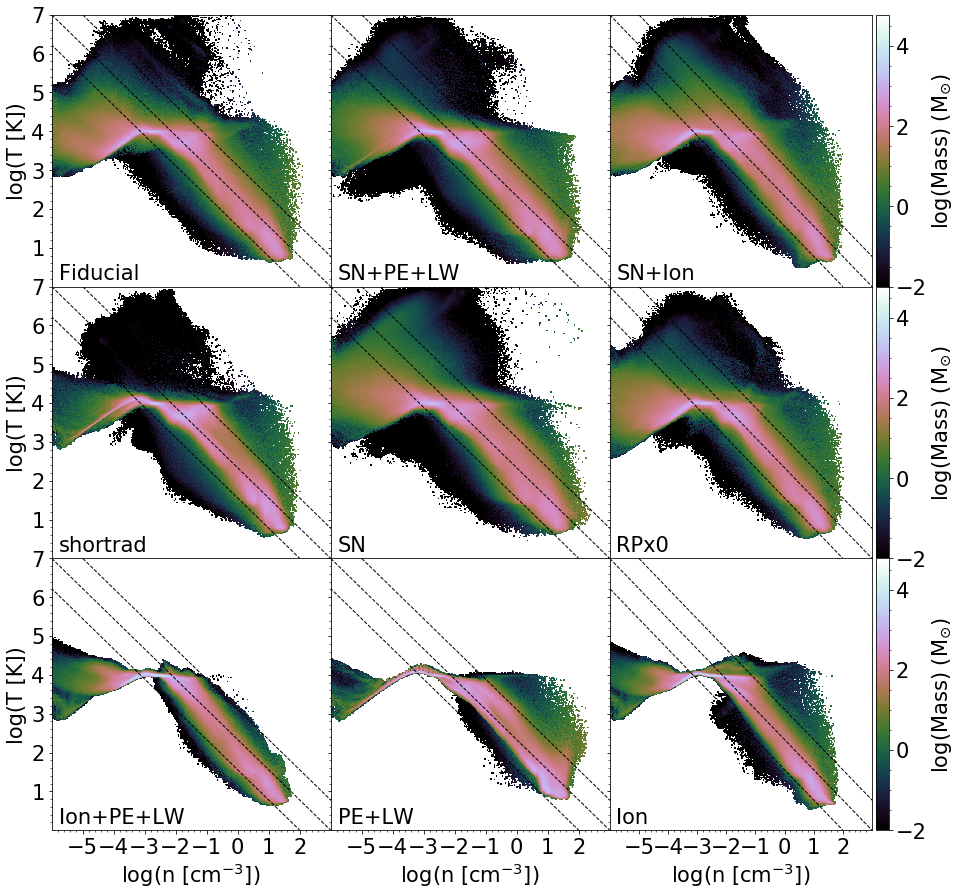

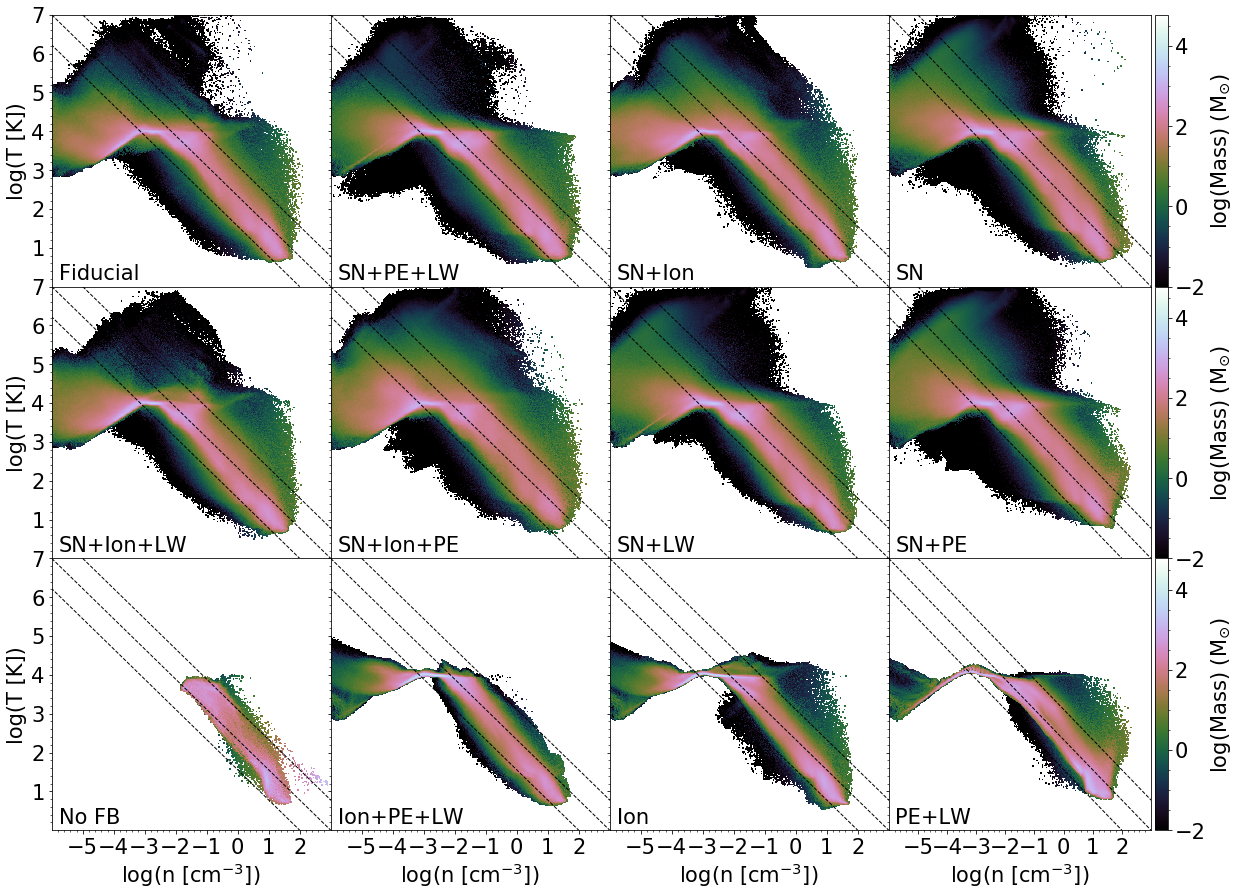

In [96]:
plot_settings()

def plot_phase_diagram(runs = None, outname=None, dims = None, phase_type = 'nT_phase_disk'):
    
    fs = 5

 
    # plot many panel phase diagram
    #
    if runs is None:

        runs = ['fiducial', 'sn_otrad_no-ion', 'sn_ion-no-otrad',
                'shortrad', 'sn_only', 'sn_otrad_ion_noRP',
                'otrad_ion-no-sn', 'otrad_no-ion-sn', 'ion_no-otrad-sn']
        
    nruns = np.size(runs)
        
    if dims is None:
        
        if nruns >= 7 and nruns <=9:
            nrow, ncol = 3,3
        elif nruns <= 4:
            nrow, ncol = 2,2
        elif nruns > 4 and nruns <= 6:
            nrow, ncol = 2,3
        elif nruns > 9 and nruns <=12:
            
            nrow,ncol = 3,4
        elif nruns > 12:
            nrow,ncol = 4,4
    else:
        nrow,ncol = dims[0],dims[1]
            
    if nruns > nrow * ncol:
        raise ValueError
        
            
    fig, ax = plt.subplots(nrow,ncol, sharex=True, sharey=True)
    fig.set_size_inches(fs*ncol,fs*nrow)
    fig.subplots_adjust(wspace=0,hspace=0)

    #
    #phase_type = 'nT_phase_disk'
    #phase_type = "nT_phase_outside_disk"

    axi,axj=0,0
    for i,run in enumerate(runs):
        axindex = (axi,axj)


        if axi == (nrow-1):
            ax[axindex].set_xlabel(r"log(n [cm$^{-3}$])")
            ax[axindex].set_xticks([-5,-4,-3,-2,-1,0,1,2])

        if axj == 0:
            ax[axindex].set_ylabel(r"log(T [K])")
            ax[axindex].set_yticks([1,2,3,4,5,6,7])


        # iterate for now to work woth continue
        axj = axj + 1
        if axj >= ncol:
            axj = 0
            axi = axi + 1

        if all_data[run] is None:
            print(run, " is None")

        elif all_data[run].data('nT_phase_disk') is None:
            print("Skipping phase diagram for run " + run)
            continue

        phase_data = all_data[run].data(phase_type)

        xmesh = phase_data['2D']['nmesh']
        ymesh = phase_data['2D']['Tmesh']
        zmesh = phase_data['2D']['hist']
        im = ax[axindex].pcolormesh( np.log10(xmesh), np.log10(ymesh), np.log10(zmesh.T), cmap = 'cubehelix',
                                #norm = LogNorm(),
                                     vmin=np.log10(0.01), vmax = np.log10(6.0E4))

        #ax[axindex].annotate(xy,xytext=)
        #ax[axindex].semilogx()
        #ax[axindex].semilogy()
        ax[axindex].set_xlim(-6,3)
        ax[axindex].set_ylim(0,7)

        ax[axindex].plot( [-6,3], [7,0], lw = 1, ls = '--', color = 'black')
        ax[axindex].plot( [-5,4], [7,0], lw = 1, ls = '--', color = 'black')
        ax[axindex].plot( [-7,2], [7,0], lw = 1, ls = '--', color = 'black')


        if axindex[1] == ncol - 1 :
            divider = make_axes_locatable(ax[axindex])
            cax     = divider.append_axes("right", size="5%", pad=0.05)    


            c = fig.colorbar(im, cax=cax)
            c.set_label(r"log(Mass) (M$_{\odot}$)")


        xy = (0.025,0.025)
        ax[axindex].annotate( labels[run], xy=xy,xycoords='axes fraction')

        plt.minorticks_on()

    if outname is None:
        outname = "phase_plot_" + phase_type + ".png"    

    fig.savefig(outname)

plot_phase_diagram()

phase_runs =  ['fiducial','sn_otrad_no-ion','sn_ion-no-otrad','sn_only',
                            'snlw','snpe','snlw_noion','snpe_noion',
                            'nofeed','otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn']
plot_phase_diagram( runs = phase_runs,
                   dims = (3,4),
                   outname = 'phase_plot_nT_disk_4x2.png')



Skipping phase diagram for run nofeed


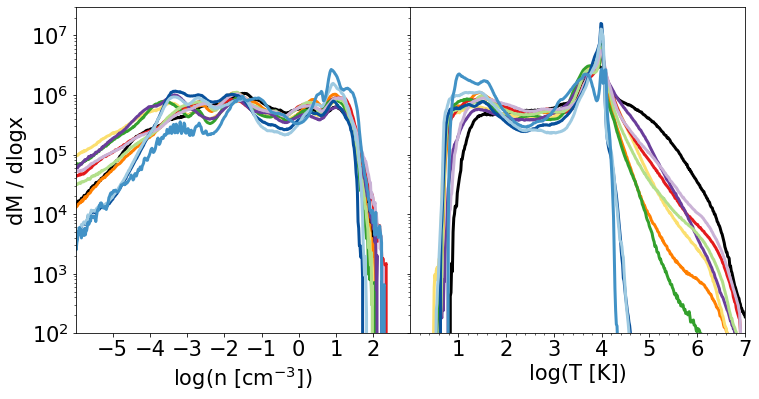

Skipping phase diagram for run nofeed


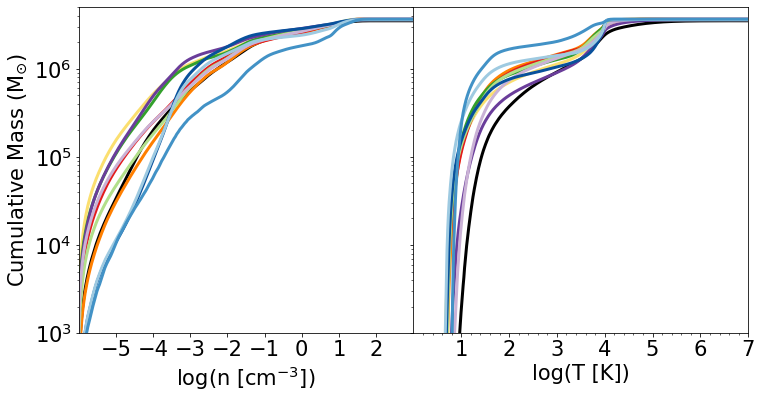

Skipping phase diagram for run nofeed


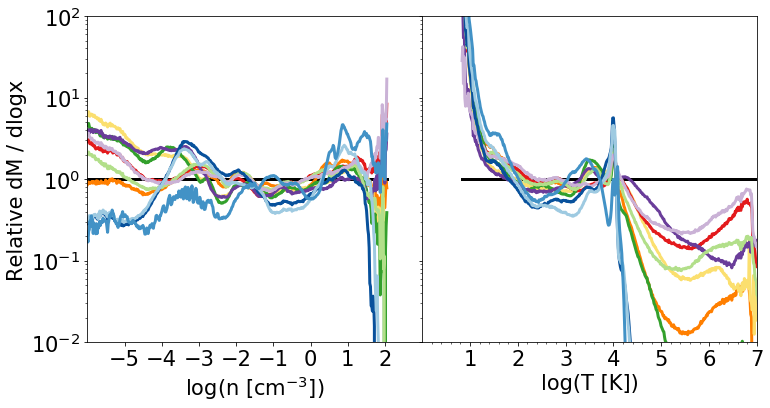

In [35]:
plot_settings()

runs = ['fiducial', 'sn_otrad_no-ion', 'sn_ion-no-otrad',
        'shortrad', 'sn_only', 'sn_otrad_ion_noRP',
        'otrad_ion-no-sn', 'otrad_no-ion-sn', 'ion_no-otrad-sn','fiducial']

runs = phase_runs

phase_type = 'nT_phase_disk'
#phase_type = "nT_phase_outside_disk"


sharey=True

fig, ax = plt.subplots(1,2,sharey=sharey)
fig.set_size_inches(12,6)

if sharey:
    fig.subplots_adjust(wspace=0)
#
# plot many panel phase diagram
#


for i,run in enumerate(runs):    
    
    ax[0].set_xlabel(r"log(n [cm$^{-3}$])")
    ax[0].set_xticks([-5,-4,-3,-2,-1,0,1,2])
        
    ax[1].set_xlabel(r"log(T [K])")
    ax[1].set_xticks([1,2,3,4,5,6,7])
        
    if all_data[run].data('nT_phase_disk') is None:
        print("Skipping phase diagram for run " + run)
        continue
        
    phase_data = all_data[run].data(phase_type)
        
    nbins = phase_data['1D']['nbins']
    nhist = phase_data['1D']['nhist']
    Tbins = phase_data['1D']['Tbins']
    Thist = phase_data['1D']['Thist']
    
    ax[0].plot(np.log10(nbins), nhist / (np.log10(nbins[1])-np.log10(nbins[0])),# where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])
    ax[1].plot(np.log10(Tbins), Thist / (np.log10(Tbins[1])-np.log10(Tbins[0])),# where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])

    ax[0].set_xlim(-6,3)
    ax[1].set_xlim(0,7)
    
    
    
    plt.minorticks_on()

for a in ax:
    a.semilogy()
    a.set_ylim(100,3.0E7)
    
if not sharey:
    ax[0].set_ylabel("dM / dlogn")
    ax[1].set_ylabel("dM / dlogT")
    plt.tight_layout()
else:
    ax[0].set_ylabel(r"dM / dlogx")
                     
fig.savefig("1D_phase_plot_" + phase_type + ".png")
plt.show()
plt.close()
#
#
# plot cumulative
#
#



fig, ax = plt.subplots(1,2,sharey=sharey)
fig.set_size_inches(12,6)
if sharey:
    fig.subplots_adjust(wspace=0)
for i,run in enumerate(runs):    
    
    ax[0].set_xlabel(r"log(n [cm$^{-3}$])")
    ax[0].set_xticks([-5,-4,-3,-2,-1,0,1,2])
        
    ax[1].set_xlabel(r"log(T [K])")
    ax[1].set_xticks([1,2,3,4,5,6,7])
        
    if all_data[run].data('nT_phase_disk') is None:
        print("Skipping phase diagram for run " + run)
        continue
        
    phase_data = all_data[run].data(phase_type)
        
    nbins = phase_data['1D']['nbins']
    nhist = phase_data['1D']['nhist']
    Tbins = phase_data['1D']['Tbins']
    Thist = phase_data['1D']['Thist']
    
    ax[0].plot(np.log10(nbins), np.cumsum(nhist),# where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])
    ax[1].plot(np.log10(Tbins), np.cumsum(Thist), # where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])

    ax[0].set_xlim(-6,3)
    ax[1].set_xlim(0,7)
    
    
    
    plt.minorticks_on()

for a in ax:
    a.semilogy()
    a.set_ylim(1000,5.0E6)
    
ax[0].set_ylabel(r"Cumulative Mass (M$_{\odot}$)")
if not sharey:
    ax[1].set_ylabel(r"Cumulative Mass (M$_{\odot}$)")
    plt.tight_layout()

fig.savefig("1D_phase_plot_cumulative_" + phase_type + ".png")
plt.show()
plt.close()


#
#
# plot fraction
#
#


fig, ax = plt.subplots(1,2,sharey=sharey)
fig.set_size_inches(12,6)
if sharey:
    fig.subplots_adjust(wspace=0)
#phase_type = "nT_phase_outside_disk"

n_norm = all_data['fiducial'].data(phase_type)['1D']['nhist']
T_norm = all_data['fiducial'].data(phase_type)['1D']['Thist']

for i,run in enumerate(runs):    
    
    ax[0].set_xlabel(r"log(n [cm$^{-3}$])")
    ax[0].set_xticks([-5,-4,-3,-2,-1,0,1,2])
        
    ax[1].set_xlabel(r"log(T [K])")
    ax[1].set_xticks([1,2,3,4,5,6,7])
        
    if all_data[run].data('nT_phase_disk') is None:
        print("Skipping phase diagram for run " + run)
        continue
        
    phase_data = all_data[run].data(phase_type)
        
    nbins = phase_data['1D']['nbins']
    nhist = phase_data['1D']['nhist']
    Tbins = phase_data['1D']['Tbins']
    Thist = phase_data['1D']['Thist']
    
    ax[0].plot(np.log10(nbins[n_norm>0]), nhist[n_norm>0] / n_norm[n_norm>0],# where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])
    ax[1].plot(np.log10(Tbins[T_norm>0]), Thist[T_norm>0] / T_norm[T_norm>0], # where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])

    ax[0].set_xlim(-6,3)
    ax[1].set_xlim(0,7)
    
    
    
    plt.minorticks_on()

for a in ax:
    a.semilogy()
    a.set_ylim(0.01,100.0)
    

if not sharey:
    ax[0].set_ylabel("Relative dM / dlogn")    
    ax[1].set_ylabel("Relative dT / dlogT")
    plt.tight_layout()
else:
    ax[0].set_ylabel("Relative dM / dlogx")

fig.savefig("1D_phase_plot_relative_" + phase_type + ".png")


plt.show()
plt.close()


['sn_ion-no-otrad',
 'sn_otrad_no-ion',
 'sn_only',
 'otrad_ion-no-sn',
 'ion_no-otrad-sn',
 'otrad_no-ion-sn',
 'sn_otrad_ion_noRP',
 'shortrad',
 'fiducial']

No handles with labels found to put in legend.


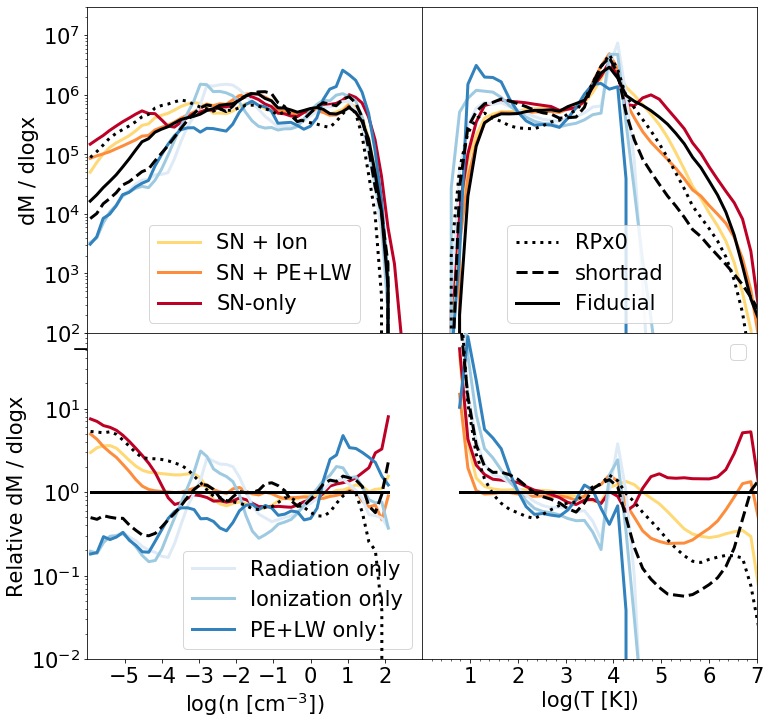

In [13]:
def plot_1D_phase_PDFs(runs = base_comparison, outname = "1D_phase_plot_2panel",
                       phase_type = 'nT_phase_disk'):
    
    outname = outname + '_' +phase_type + '.png'
    #phase_type = 'nT_phase_disk'
    #phase_type = "nT_phase_outside_disk"
    
    plot_settings()

    #runs = ['sn_otrad_no-ion', 'sn_ion-no-otrad',
    #        'shortrad', 'sn_only', 'sn_otrad_ion_noRP',
    #        'otrad_ion-no-sn', 'otrad_no-ion-sn', 'ion_no-otrad-sn','fiducial']




    sharex,sharey=True,True

    fig, all_axes = plt.subplots(2,2)
    fig.set_size_inches(12,12)

    if sharey:
        fig.subplots_adjust(wspace=0)
    if sharex:
        fig.subplots_adjust(hspace=0)
    #
    # plot many panel phase diagram
    #
    ax = all_axes[0]
    factor = 0.174


    runs_to_label1 = ['sn_otrad_no-ion','sn_ion-no-otrad','sn_only']
    runs_to_label2 = ['fiducial','shortrad','sn_otrad_ion_noRP']
    runs_to_label3 = ['otrad_no-ion-sn','ion_no-otrad-sn','otrad_ion-no-sn']
    runs_to_label4 = []


    for i,run in enumerate(runs):    

        if all_data[run].data('nT_phase_disk') is None:
            print("Skipping phase diagram for run " + run)
            continue

        phase_data = all_data[run].data(phase_type)

        nbins_orig = phase_data['1D']['nbins']
        nhist_orig = phase_data['1D']['nhist']

        nbins_new = np.zeros(np.size(nbins_orig)+1)
        nbins_new[:-1] = np.log10(nbins_orig) - 0.5*np.average(np.log10(nbins_orig[1:]) - np.log10(nbins_orig[:-1]))
        nbins_new[-1] = nbins_new[-2] + np.average(np.log10(nbins_orig[1:]) - np.log10(nbins_orig[:-1]))



        Tbins_orig = phase_data['1D']['Tbins']
        Thist_orig = phase_data['1D']['Thist']


        nbins, nhist = utilities.simple_rebin(nbins_new, nhist_orig,factor)
        Tbins, Thist = utilities.simple_rebin(np.log10(Tbins_orig),Thist_orig[:-1],factor)

        nplot = 0.5 * (nbins[1:]+nbins[:-1])
        Tplot = 0.5 * (Tbins[1:]+Tbins[:-1])

        if run in runs_to_label1:
            label = labels[run]
        else:
            label = None

        ax[0].plot(nplot, nhist / (nbins[1]-nbins[0]),# where = 'pre',
                          color = colors[run], 
                          label = label,
                          lw=3, ls = lstyles[run], zorder=i)
        if run in runs_to_label2:
            label = labels[run]
        else:
            label = None

        ax[1].plot(Tplot, Thist / (Tbins[1]-Tbins[0]),# where = 'pre',
                          color = colors[run], 
                          label = label,
                          lw=3, ls = lstyles[run], zorder=i)

        ax[0].set_xlim(-6,3)
        ax[1].set_xlim(0,7)



        plt.minorticks_on()


    if not sharex:
        ax[0].set_xlabel(r"log(n [cm$^{-3}$])")
        ax[0].set_xticks([-5,-4,-3,-2,-1,0,1,2])

    if not sharex:
        ax[1].set_xlabel(r"log(T [K])")
        ax[1].set_xticks([1,2,3,4,5,6,7])    

    for a in ax:
        a.semilogy()
        a.set_ylim(100,3.0E7)

    if not sharey:
        ax[0].set_ylabel("dM / dlogn")
        ax[1].set_ylabel("dM / dlogT")
        plt.tight_layout()
    else:
        ax[0].set_ylabel(r"dM / dlogx")
        ax[1].get_yaxis().set_visible(False)


    #
    #
    # plot fraction
    #
    #
    ax = all_axes[1]

    n_norm_orig = all_data['fiducial'].data(phase_type)['1D']['nhist']
    T_norm_orig = all_data['fiducial'].data(phase_type)['1D']['Thist']

    for i,run in enumerate(runs):    

        if all_data[run].data('nT_phase_disk') is None:
            print("Skipping phase diagram for run " + run)
            continue

        phase_data = all_data[run].data(phase_type)

        nbins_orig = phase_data['1D']['nbins']
        nhist_orig = phase_data['1D']['nhist']


        Tbins_orig = phase_data['1D']['Tbins']
        Thist_orig = phase_data['1D']['Thist']


        nbins, nhist = utilities.simple_rebin(np.log10(nbins_orig),nhist_orig[:-1],factor)
        Tbins, Thist = utilities.simple_rebin(np.log10(Tbins_orig),Thist_orig[:-1],factor)


        nbins_norm, n_norm = utilities.simple_rebin(np.log10(nbins_orig), n_norm_orig[:-1], factor)
        Tbins_norm, T_norm = utilities.simple_rebin(np.log10(Tbins_orig), T_norm_orig[:-1], factor)

        nplot=0.5*(nbins[1:] + nbins[:-1])
        Tplot=0.5*(Tbins[1:] + Tbins[:-1])

        if run in runs_to_label3:
            label = labels[run]
        else:
            label = None


        ax[0].plot(nplot[n_norm>0], (nhist[n_norm>0]/np.sum(nhist))/ (n_norm[n_norm>0]/np.sum(n_norm)),# where = 'pre',
                          color = colors[run], 
                          label = label,
                          lw=3, ls = lstyles[run],zorder=i)

        if run in runs_to_label4:
            label = labels[run]
        else:
            label = None

        ax[1].plot(Tplot[T_norm>0], (Thist[T_norm>0]/np.sum(Thist)) / (T_norm[T_norm>0]/np.sum(T_norm)), # where = 'pre',
                          color = colors[run], 
                          label = label,
                          lw=3, ls = lstyles[run],zorder=i)

        ax[0].set_xlim(-6,3)
        ax[1].set_xlim(0,7)



        plt.minorticks_on()

    ax[0].set_xlabel(r"log(n [cm$^{-3}$])")
    ax[0].set_xticks([-5,-4,-3,-2,-1,0,1,2]) 
    ax[1].set_xlabel(r"log(T [K])")
    ax[1].set_xticks([1,2,3,4,5,6,7])

    for ax1 in all_axes:
        for ax2 in ax1:
            ax2.legend(loc='best')
    #ax[0].legend(loc='best',ncol=2)

    for a in ax:
        a.semilogy()
        a.set_ylim(0.01,80.0)

    if not sharey:
        ax[0].set_ylabel("Relative dM / dlogn")    
        ax[1].set_ylabel("Relative dT / dlogT")
        plt.tight_layout()

    else:
        ax[0].set_ylabel("Relative dM / dlogx")
        ax[1].get_yaxis().set_visible(False)

    fig.savefig(outname)
    
#----------------------------------------------------------------------------------------------------------

plot_1D_phase_PDFs()

/home/aemerick/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/aemerick/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


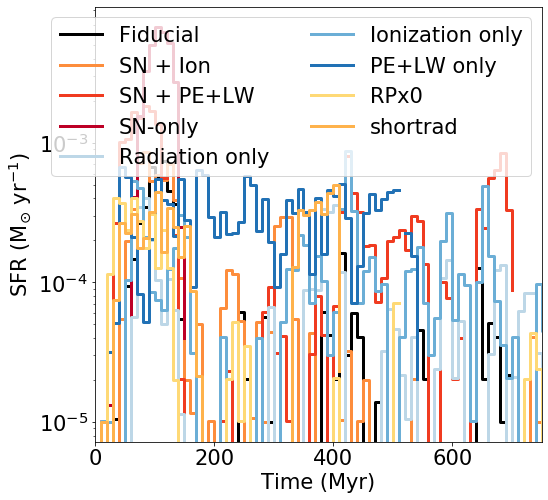

In [385]:
#
# plot a SFR comparison
#
plot_settings()

fig, ax = plt.subplots()
fig.set_size_inches(8,8)

runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
    SFR = all_data[run].load_single('/time_data/SFR',index = -1)
    
   # print(np.shape(t),np.shape(SFR[:-1])) 
    new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

    t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, 10.0, method='average')    
    if run == 'fiducial':
        color = 'black'
    else:
        color = "C%0i"%(i)    
    ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = colors[run], ls=lstyles[run])
    #ax.plot(t[:-1], SFR, label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
ax.set_xlabel(r'Time (Myr)')
ax.set_ylabel(r'SFR (M$_{\odot}$ yr$^{-1}$)')
ax.semilogy()

ax.legend(loc='best',ncol = 2)

ax.set_xlim(global_time_lim)
#ax.set_ylim()
fig.savefig('physics_comparison_sfr.png')

x = all_data['sn_only']
x.load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') / x.load_field('M_gas')

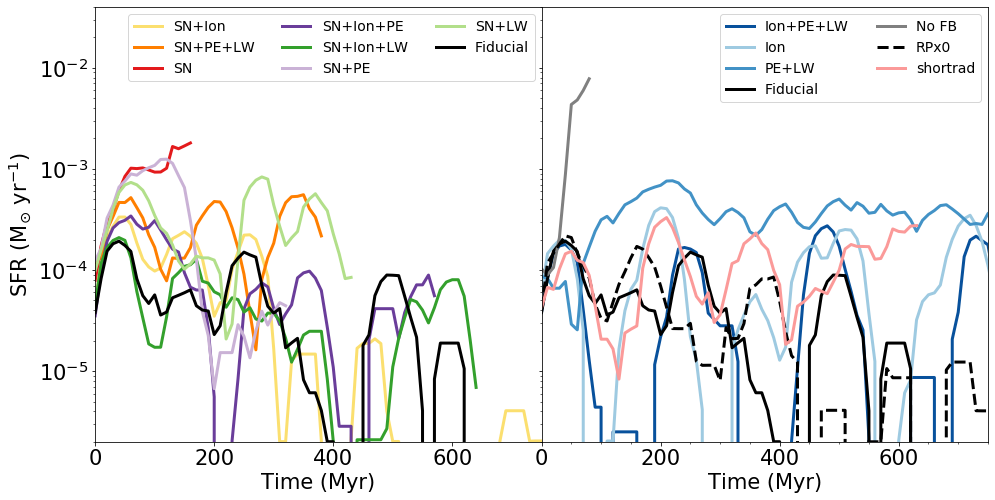

In [106]:
sfr_bin_size = 50.0

def plot_sfr(runs_to_plot   = None,
             runs_to_plot2  = None,
             outname = 'physics_comparison_sfr_2.png'):
    
    
    if runs_to_plot is None:
        runs_to_plot = sn_runs + misc_runs + ['fiducial']
        
    if runs_to_plot2 is None:
        runs_to_plot2 = no_sn_runs + ['fiducial']

    #
    # plot a SFR comparison
    #
    plot_settings()

    fig, axes = plt.subplots(1,2,sharey=True)
    fig.set_size_inches(16,8)

    fig.subplots_adjust(wspace=0)

    #runs_to_plot = base_comparison

    ax = axes[0]
    for i,run in enumerate(runs_to_plot):
        #t = all_data[run].data('time')

        #t = t - t[0]

        # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
        t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
        SFR = all_data[run].load_single('/time_data/SFR',index = -1)

       # print(np.shape(t),np.shape(SFR[:-1])) 
        new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

        #t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, sfr_bin_size, method='average')
        #print(run,t[0])
        SFR = utilities.window_average(t-t[0],
                                         SFR, sfr_bin_size, method='average', where='mid')
        if run == 'fiducial':
            color = 'black'
        else:
            color = "C%0i"%(i)    
        #ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = colors[run], ls=lstyles[run])
        
        
        ax.plot(t-t[0], SFR, label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

        plt.minorticks_on()


    ax = axes[1]
    
    
    
    
    for i,run in enumerate(runs_to_plot2):
        #t = all_data[run].data('time')

        #t = t - t[0]

        # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
        t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
        SFR = all_data[run].load_single('/time_data/SFR',index = -1)

       # print(np.shape(t),np.shape(SFR[:-1])) 
        new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

        #SFR[SFR<1.0E-6]=

        #t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, sfr_bin_size, method='average')    
        SFR = utilities.window_average(t-t[0],SFR, sfr_bin_size, method='average', where='mid')
        
        if run == 'fiducial':
            color = 'black'
        else:
            color = "C%0i"%(i)    
        #ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = colors[run], ls=lstyles[run])
        ax.plot(t-t[0], SFR, label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

        plt.minorticks_on()

    for ax in axes:
        ax.set_xlabel(r'Time (Myr)')
        ax.semilogy()
        ax.set_xlim(global_time_lim)
        ax.set_ylim(2.0E-6,4.0E-2)
        
    legend_prop = {'size' : 14}
        
    axes[0].legend(ncol = 3,loc = 'upper right', prop = legend_prop)
    axes[1].legend(loc='best',ncol = 2, prop = legend_prop)
    axes[0].set_ylabel(r'SFR (M$_{\odot}$ yr$^{-1}$)')



    #ax.set_ylim()
    fig.savefig(outname)

#plot_sfr()
#lstyles
plot_sfr(sn_runs + ['snpe','snlw','snpe_noion','snlw_noion'] + ['fiducial'],
         no_sn_runs + ['fiducial','nofeed','sn_otrad_ion_noRP','shortrad'],
         'physics_comparison_sfr.png')

label_set_1 = sn_runs + ['snpe','snlw','snpe_noion','snlw_noion'] + ['fiducial']
label_set_2 = no_sn_runs + ['fiducial','nofeed','sn_otrad_ion_noRP','shortrad']

In [79]:
x = all_data['fiducial']


SyntaxError: invalid syntax (<ipython-input-79-9ae84f117e66>, line 2)

In [86]:
np.average(x.data('SFR_1'))

2.964057580430705e-05

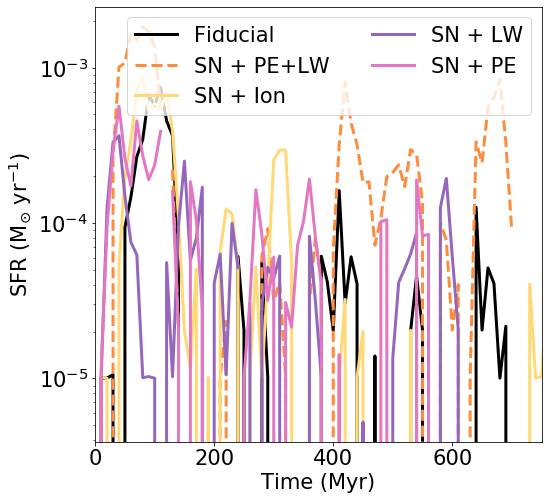

In [15]:
#
# plot a SFR comparison
#
plot_settings()

fig, ax = plt.subplots()
fig.set_size_inches(8,8)

runs_to_plot = ['fiducial', 'sn_otrad_no-ion', 'sn_ion-no-otrad',
                
                'snlw', 'snpe']

temp_colors  = {'fiducial' : colors['fiducial'],
                'sn_otrad_no-ion' : colors['sn_otrad_no-ion'],
                 'sn_ion-no-otrad': colors['sn_ion-no-otrad'],
                'snlw' : 'C4',
                'snpe' : 'C6'}

temp_lstyles = {}
for k in runs_to_plot:
    temp_lstyles[k] = lstyles[k]
temp_lstyles['snlw'] = '-'
temp_lstyles['snpe'] = '-'
temp_lstyles['sn_otrad_no-ion'] = '--'

for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
    SFR = all_data[run].load_single('/time_data/SFR',index = -1)
    
   # print(np.shape(t),np.shape(SFR[:-1])) 
    new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

    t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, 10.0, method='average')    
    if run == 'fiducial':
        color = 'black'
    else:
        color = "C%0i"%(i)    
    #ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = temp_colors[run], 
                                                                 #     ls    = temp_lstyles[run])
    ax.plot(t[:-1], SFR, label = labels[run], lw = 3, color = temp_colors[run], ls=temp_lstyles[run])
    
ax.set_xlabel(r'Time (Myr)')
ax.set_ylabel(r'SFR (M$_{\odot}$ yr$^{-1}$)')
ax.semilogy()

ax.legend(loc='best',ncol = 2)

ax.set_xlim(global_time_lim)
#ax.set_ylim()
fig.savefig('physics_comparison_OT_radiation.png')

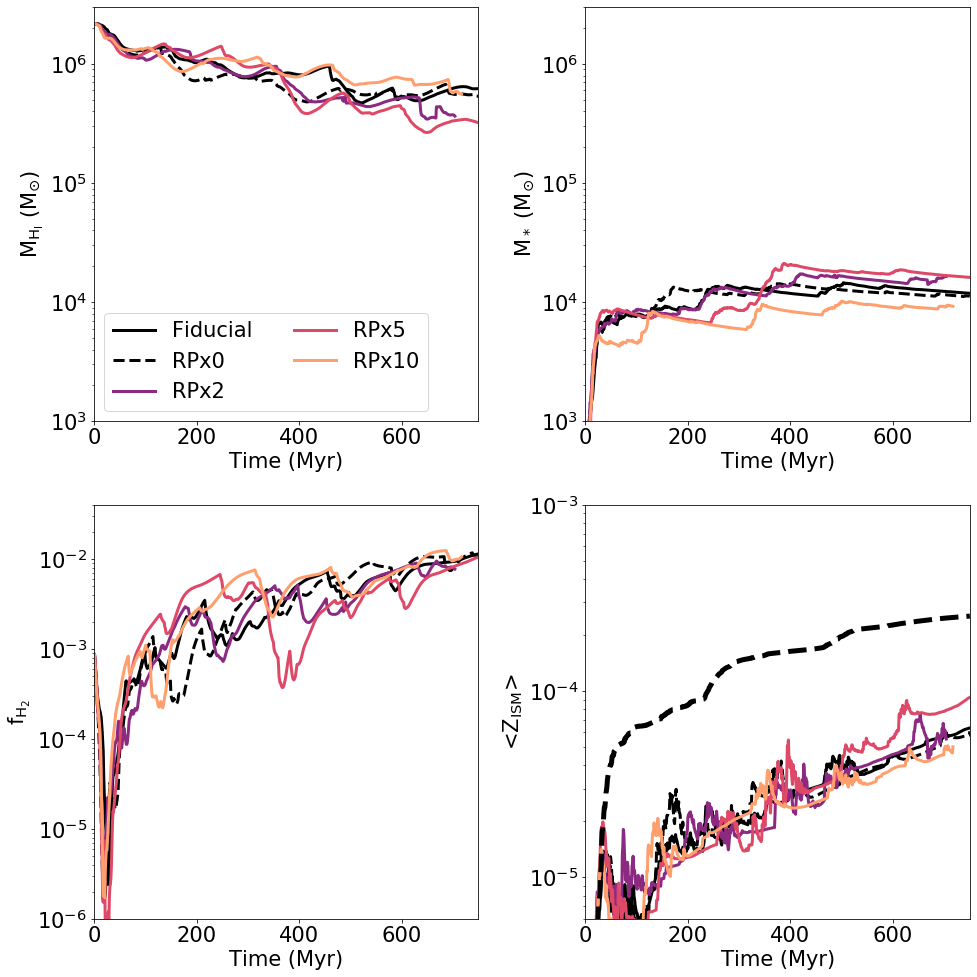

In [112]:
#
# plot a mass comparison
#


fig, axes = plt.subplots(2,2)
fs = 7
fig.set_size_inches(fs*2,fs*2)


ax_fields = ['M_HI','M_star','M_H2_total','Z']
ax_labels = [r'M$_{\rm H_I}$ (M$_{\odot}$)', r'M$_{\rm *}$ (M$_{\odot}$)',
             #r'M$_{\rm H_2}$ (M$_{\odot}$)', 
             r'f$_{\rm H_2}$', 
             r'<Z$_{\rm ISM}$>']
ylims = [ [1.0E3,3.0E6], [1.0E3,3.0E6], [1.0E-6,4.0E-2], [6.0E-6,1.0E-3]]             

runs_to_plot = ['fiducial', 'sn_otrad_ion_noRP', 'sn_otrad_ion_RPx2', 'sn_otrad_ion_RPx5','sn_otrad_ion_RPx10']

index = 0
axi = axj = 0
for ax1 in axes:
    
    axj = 0
    for ax2 in ax1:
        
        ax_index = (axi,axj)

        for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
       
            x = all_data[run].data('time')
            
            if ax_fields[index] == 'Z':
                y = all_data[run].load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') /\
                    all_data[run].data('M_gas')
                
               # y = all_data[run].data('M_star')
                
            elif ax_fields[index] == 'M_H2_total':
                y = all_data[run].data('M_H2_total') / all_data[run].data('M_gas')
                #print(run,y)
            else:
                
                y = all_data[run].data(ax_fields[index])
            
            x = x - x[0]

            ax2.plot(x,y, label = labels[run], lw = 3, color = colors[run], ls = lstyles[run])

        ax2.set_ylabel(ax_labels[index])            
        ax2.set_xlabel(r'Time (Myr)')
        ax2.set_xlim(global_time_lim)
        ax2.semilogy()
        ax2.set_ylim(ylims[index])
        
        ax2.tick_params(axis='x', which='minor', bottom=True)
        #ax2.tick_params(axis='y', which='minor', bottom=True)

        
        
        index = index + 1
 
             
        axj = axj + 1
        
    axi = axi + 1
    
    
closed_box = True

# overplot closed box model for fiducial run
if closed_box:
    y = all_data['fiducial'].load_field('/gas_meta_data/masses/OutsideBox/Total Tracked Metals') +\
        all_data['fiducial'].load_field('/gas_meta_data/masses/FullBox/Total Tracked Metals')
    #print(y)
    y = y / all_data['fiducial'].load_field('M_gas')[0]
    x = all_data['fiducial'].load_field('time')
    
    axes[(1,1)].plot(x - x[0], y, color = 'black', ls = '--', lw = 5, label = 'Closed Box')
   # axes[(1,1)].legend(loc='best')
    

axes[(0,0)].legend(loc='best',ncol=2)


plt.tight_layout()

fig.savefig("physics_comparison_masses_RP.png")

In [12]:
colors['snlw']

'C8'

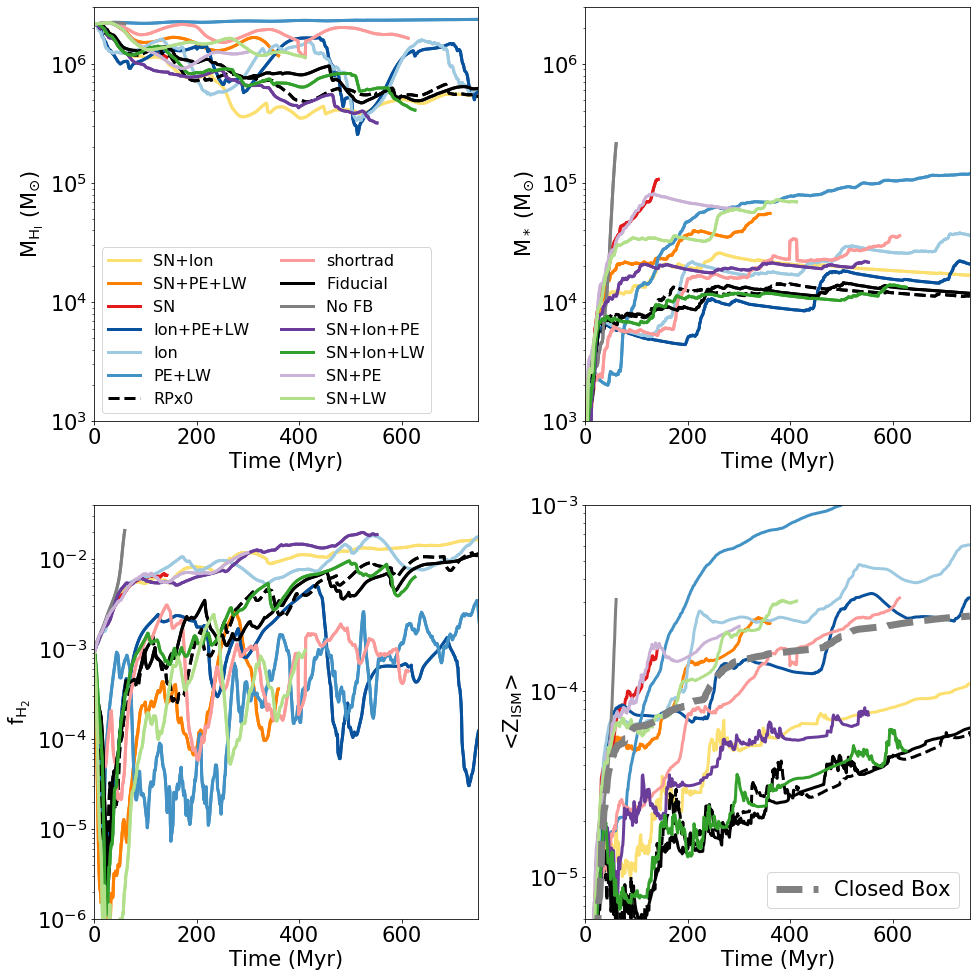

In [103]:
plot_settings()

def plot_masses_comparison(runs_to_plot=base_comparison, labels1=None, labels2=None,
                           outname='physics_comparison_masses.png'):
    #
    # plot a mass comparison
    #
    
    if labels1 is None:
        labels1 = runs_to_plot
        

    fig, axes = plt.subplots(2,2)
    fs = 7
    fig.set_size_inches(fs*2,fs*2)


    ax_fields = ['M_HI','M_star','M_H2_total','Z']
    ax_labels = [r'M$_{\rm H_I}$ (M$_{\odot}$)', r'M$_{\rm *}$ (M$_{\odot}$)',
                 #r'M$_{\rm H_2}$ (M$_{\odot}$)', 
                 r'f$_{\rm H_2}$', 
                 r'<Z$_{\rm ISM}$>']
    ylims = [ [1.0E3,3.0E6], [1.0E3,3.0E6], [1.0E-6,4.0E-2], [6.0E-6,1.0E-3]]             

    #runs_to_plot = base_comparison #+ ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5'] # + ['snlw','snpe']


    index = 0
    axi = axj = 0
    for ax1 in axes:

        axj = 0
        for ax2 in ax1:

            ax_index = (axi,axj)

            for i,run in enumerate(runs_to_plot):
        #t = all_data[run].data('time')

        #t = t - t[0]

                x = all_data[run].data('time')

                if ax_fields[index] == 'Z':
                    y = all_data[run].load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') /\
                        all_data[run].data('M_gas')

                   # y = all_data[run].data('M_star')

                elif ax_fields[index] == 'M_H2_total':
                    y = all_data[run].data('M_H2_total') / all_data[run].data('M_gas')
                else:

                    y = all_data[run].data(ax_fields[index])

                x = x - x[0]

                if ax_fields[index] == 'Z':
                    ax2.plot(x,y,lw=3,color=colors[run],ls=lstyles[run])
                else:
                    
                    if labels1 is None:
                        
                        ax2.plot(x,y, lw = 3, color = colors[run], ls = lstyles[run])

                    elif (axi == 0) and (axj == 0) and run in labels1:                    
                        ax2.plot(x,y, label = labels[run], lw = 3, color = colors[run], ls = lstyles[run])
                    else:
                        ax2.plot(x,y, lw = 3, color = colors[run], ls = lstyles[run])
 
                    if labels2 is None:
                        
                        ax2.plot(x,y, lw = 3, color = colors[run], ls = lstyles[run])

                    elif (axi == 0) and (axj == 1) and run in labels2:                    
                        ax2.plot(x,y, label = labels[run], lw = 3, color = colors[run], ls = lstyles[run])
                    else:
                        ax2.plot(x,y, lw = 3, color = colors[run], ls = lstyles[run])
                                        

            ax2.set_ylabel(ax_labels[index])            
            ax2.set_xlabel(r'Time (Myr)')
            ax2.set_xlim(global_time_lim)
            ax2.semilogy()
            ax2.set_ylim(ylims[index])

            ax2.tick_params(axis='x', which='minor', bottom=True)
            #ax2.tick_params(axis='y', which='minor', bottom=True)


            index = index + 1


            axj = axj + 1

        axi = axi + 1


    closed_box = True

    # overplot closed box model for fiducial run
    if closed_box:
        y = 1.0*all_data['fiducial'].load_field('/gas_meta_data/masses/OutsideBox/Total Tracked Metals')
        #print(y[649] - y[650])

        #y[650:] = y[650:] + 513.927    

        y = y +  all_data['fiducial'].load_field('/gas_meta_data/masses/FullBox/Total Tracked Metals')
        y = y / all_data['fiducial'].load_field('M_gas')[0]
        x = all_data['fiducial'].load_field('time')

        axes[(1,1)].plot(x - x[0], y, color = 'grey', ls = '--', lw = 7, label = 'Closed Box')
        axes[(1,1)].legend(loc='best')
       # axes[(1,1)].legend(loc='best')


    legend_prop = {'size':16}
    axes[(0,0)].legend(loc='best',ncol=2,prop=legend_prop)
    if not (labels2 is None):
        axes[(0,1)].legend(loc='best',ncol=1,prop=legend_prop)


    plt.tight_layout()

    fig.savefig(outname)
    
#plot_masses_comparison()

plot_masses_comparison(base_comparison + ['nofeed','snpe','snlw',
                                               'snpe_noion','snlw_noion'],
                       labels1 = base_comparison + ['nofeed','snpe','snlw',
                                               'snpe_noion','snlw_noion'],
                       outname= 'physics_comparison_masses.png')

#plot_masses_comparison(['fiducial-redo','sn_otrad_ion_noRP-redo',
#                        'sn_otrad_ion_RPx2-redo','sn_otrad_ion_RPx5-redo',
#                         'sn_otrad_ion_RPx10-redo'], outname = 'physics_comparison_masses_RP_redo.png')

In [61]:
x = all_data['fiducial']
x.t_

In [64]:
x.t_sf_start

79.999991661167

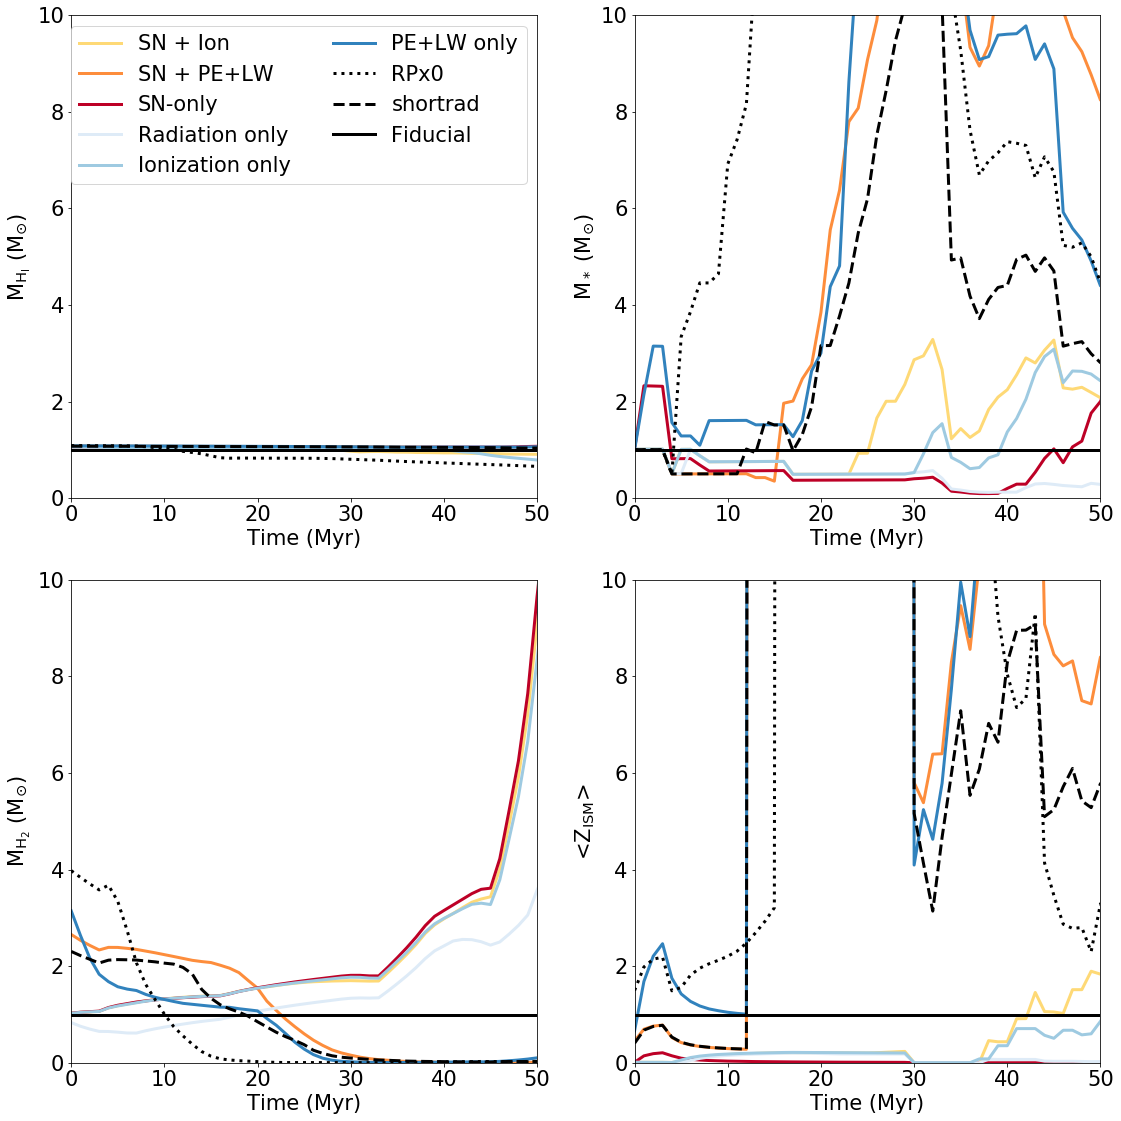

In [81]:
#
# plot a mass comparison
#


fig, axes = plt.subplots(2,2)
fs = 8
fig.set_size_inches(fs*2,fs*2)


ax_fields = ['M_HI','M_star','M_H2_total','Z']
ax_labels = [r'M$_{\rm H_I}$ (M$_{\odot}$)', r'M$_{\rm *}$ (M$_{\odot}$)',
             r'M$_{\rm H_2}$ (M$_{\odot}$)', r'<Z$_{\rm ISM}$>']
ylims = [ [1.0E4,6.0E6], [1.0E3,3.0E5], [1.0,5.0E4], [1.0E-5,3.0E-3]]  


ylims = [ [1.0E-2,1.0E2],  [1.0E-2,1.0E2], [1.0E-2,1.0E2], [1.0E-2,1.0E2] ]            


runs_to_plot = base_comparison


index = 0
axi = axj = 0
for ax1 in axes:
    
    axj = 0
    for ax2 in ax1:
        
        ax_index = (axi,axj)

        for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
       
            x = all_data[run].data('time')
            x_fiducial = all_data['fiducial'].data('time')
            
            if ax_fields[index] == 'Z':
                y = all_data[run].load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') /\
                    all_data[run].data('M_gas')
                
                
                y_fiducial = all_data['fiducial'].load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') /\
                    all_data['fiducial'].data('M_gas')
            else:
                y = all_data[run].data(ax_fields[index])
                
                y_fiducial   = all_data['fiducial'].data(ax_fields[index])
            
            
                    
            x = x - x[0]
            x_fiducial = x_fiducial - x_fiducial[0]
            
            f_fiducial = lambda t : np.interp(t, x_fiducial, y_fiducial)
            
            y = y / f_fiducial(x)

            ax2.plot(x,y, label = labels[run], lw = 3, color = colors[run], ls = lstyles[run])

        ax2.set_ylabel(ax_labels[index])            
        ax2.set_xlabel(r'Time (Myr)')
        ax2.set_xlim(0.0,50.0)
        #ax2.semilogy()
        ax2.set_ylim(0.0,10.0)
        #ax2.set_ylim(ylims[index])
        
        
        
        
        index = index + 1

        
             
        axj = axj + 1
        
    axi = axi + 1

axes[(0,0)].legend(loc='best',ncol=2)


plt.tight_layout()

fig.savefig("normalized_physics_comparison_masses.png")

In [15]:
base_comparison

['sn_ion-no-otrad',
 'sn_otrad_no-ion',
 'sn_only',
 'otrad_ion-no-sn',
 'ion_no-otrad-sn',
 'otrad_no-ion-sn',
 'sn_otrad_ion_noRP',
 'shortrad',
 'fiducial']

0.06370814726463307
0.31228265739808614
0.06370814726463307
0.31228265739808614


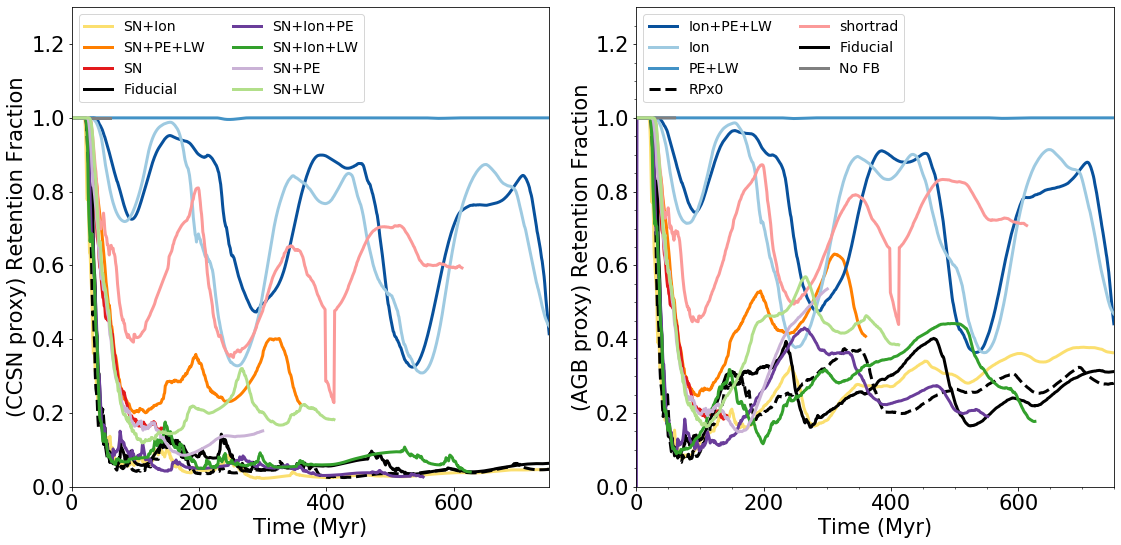

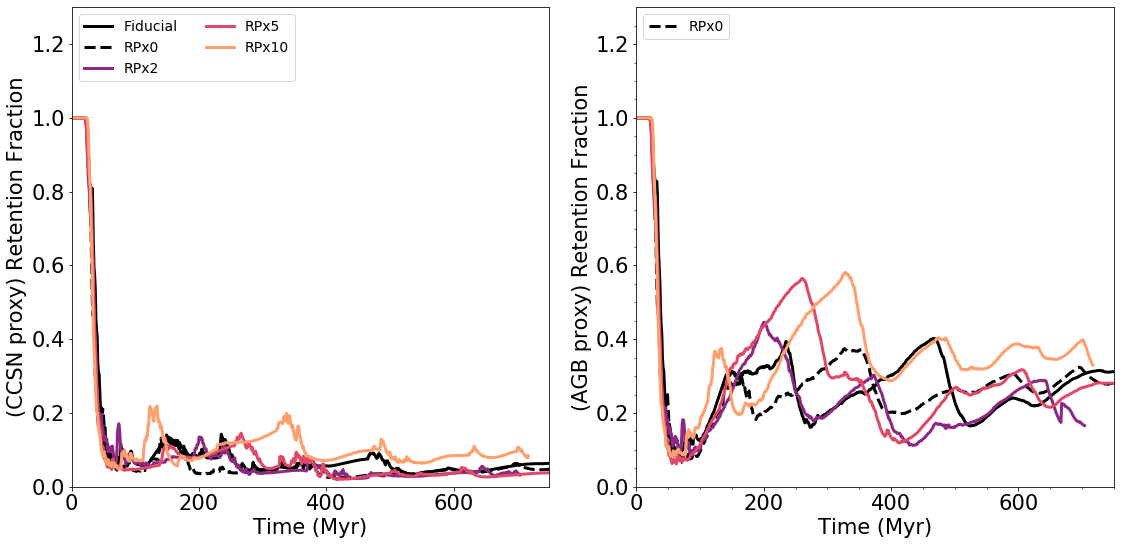

In [111]:
#
# plot a SFR comparison
#

plot_settings()

def plot_retention_comparison(runs_to_plot = base_comparison,
                              outname = "physics_comparison_retention.png",
                              labels_to_show1 = None, labels_to_show2 = None):

    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(16,8)

    plt.minorticks_on()
    
    if labels_to_show1 is None:
        labels_to_show1 = ['sn_ion-no-otrad','sn_otrad_no-ion','sn_only','shortrad','fiducial']
        
    if labels_to_show2 is None:
        labels_to_show2 = ['otrad_ion-no-sn','io_no-otrad-sn','otrad_no-ion-sn','sn_otrad_ion_noRP']


    #runs_to_plot = base_comparison + ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5']
    for i,run in enumerate(runs_to_plot):
        #t = all_data[run].data('time')

        #t = t - t[0]

        # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
        t   = all_data[run].data('time')
        t = t - t[0]

        M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
                  all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
        M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/O')
        
        if run in labels_to_show1:
            label =labels[run]
        else:
            label = None
            
        ax[0].plot(t, ( M_disk / M_tot),
                label = label, lw = 3, color = colors[run], ls=lstyles[run])
        if run == 'fiducial':
            print((M_disk/M_tot)[-1])    

        M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
                  all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
        M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Ba')

        #M_disk[t < 150] = None

        if run == 'fiducial':
            print((M_disk/M_tot)[-1])
            
        if run in labels_to_show2:
            label =labels[run]
        else:
            label = None
          
        ax[1].plot(t, (M_disk / M_tot),
                label = label, lw = 3, color = colors[run], ls=lstyles[run])    

    for a in ax:
        a.set_xlabel(r'Time (Myr)')
        a.set_xlim(global_time_lim)
        a.set_ylim(0, 1.3) #   'shortrad',
    ax[0].set_ylabel(r'(CCSN proxy) Retention Fraction')
    ax[1].set_ylabel(r'(AGB proxy) Retention Fraction')
    
    legend_prop = {'size':14}
    
    ax[0].legend(loc='upper left',ncol=2, prop=legend_prop)
    ax[1].legend(loc='upper left',ncol=2,prop=legend_prop)

#ax.semilogy()

#ax[1].legend(loc='lower right',ncol = 2)
    plt.minorticks_on()
    plt.tight_layout()
#ax.set_ylim()

    fig.savefig(outname)
    
plot_retention_comparison(full_base_comparison, labels_to_show1=label_set_1, 
                          labels_to_show2=label_set_2)
plot_retention_comparison(['fiducial','sn_otrad_ion_noRP','sn_otrad_ion_RPx2','sn_otrad_ion_RPx5','sn_otrad_ion_RPx10'],
                          labels_to_show1=['fiducial','sn_otrad_ion_noRP','sn_otrad_ion_RPx2','sn_otrad_ion_RPx5','sn_otrad_ion_RPx10'],
                          outname='physics_comparison_retention_RP.png')

In [17]:
#all_data['shortrad'].load_field('/gas_meta_data/masses/OutsideBox/O')
#
# I think this is a units issue with the newly computed data. I think I fixed the old bug
# in ENzo in gearing up for new runs but didn't update analysis scripts oops. need to do this...
# alternatively, just go through and fix ALL output DDXXXX/DDXXXX with correct units and 
# never do this again.

0.2521097489940249
0.3054578341529213


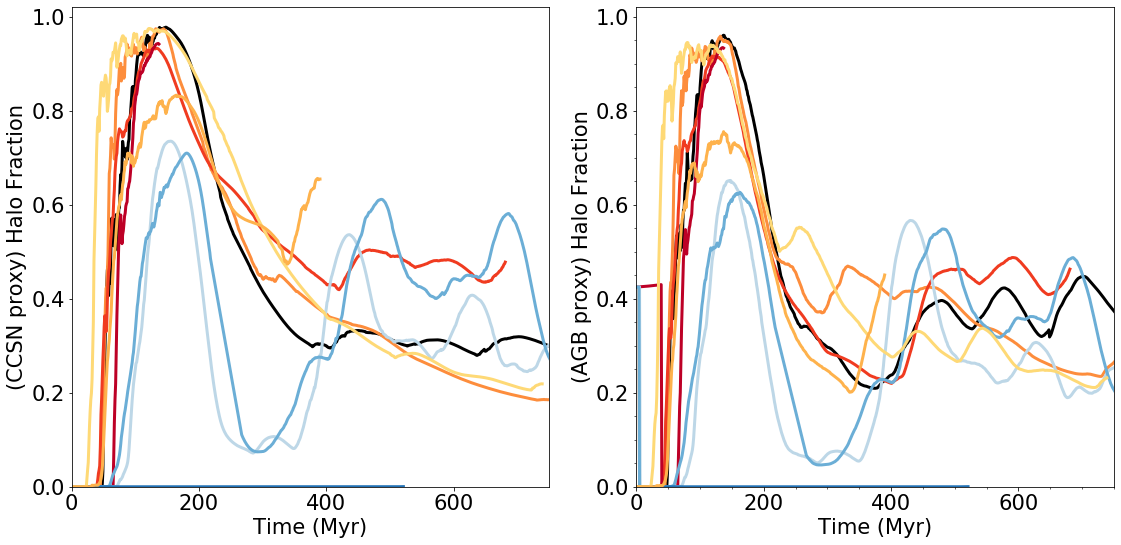

In [393]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Halo/O')
    ax[0].plot(t, ( M_disk / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])    

    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Halo/Ba')
    
    #M_disk[t < 150] = None
    
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])
    
    ax[1].plot(t, (M_disk / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(global_time_lim)
    a.set_ylim(0, 1.02) #   'shortrad',
ax[0].set_ylabel(r'(CCSN proxy) Halo Fraction')
ax[1].set_ylabel(r'(AGB proxy) Halo Fraction')

#ax.semilogy()

#ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison_halo_fraction.png")

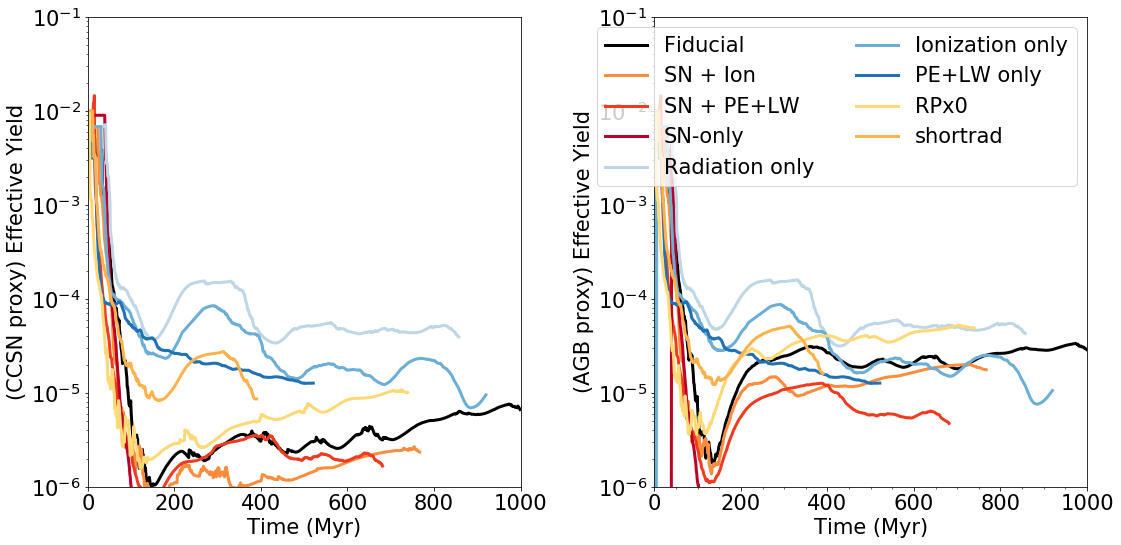

In [394]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_star = all_data[run].load_field('M_star')
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/O')
    ax[0].plot(t, ( M_disk / M_star / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    #if run == 'fiducial':
    #    ax[0].plot(t, M_tot / M_star, label='Onezone', lw=3,color='black',ls='--')
        
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Ba')
    
    #M_disk[t < 150] = None
    
    ax[1].plot(t, (M_disk / M_star / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    
    
    #if run == 'fiducial':
        #print(M_tot/M_star)
        #ax[1].plot(t, M_tot / M_star, label='Onezone', lw=3,color='black',ls='--')

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(0.0, 1000.0)
    a.semilogy()
    a.set_ylim(1.0E-6,1.0E-1)
  #  a.set_ylim() #   'shortrad',
ax[0].set_ylabel(r'(CCSN proxy) Effective Yield')
ax[1].set_ylabel(r'(AGB proxy) Effective Yield')

#ax.semilogy()

ax[1].legend(loc='upper right',ncol = 2)
plt.minorticks_on()
plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison_yield.png")

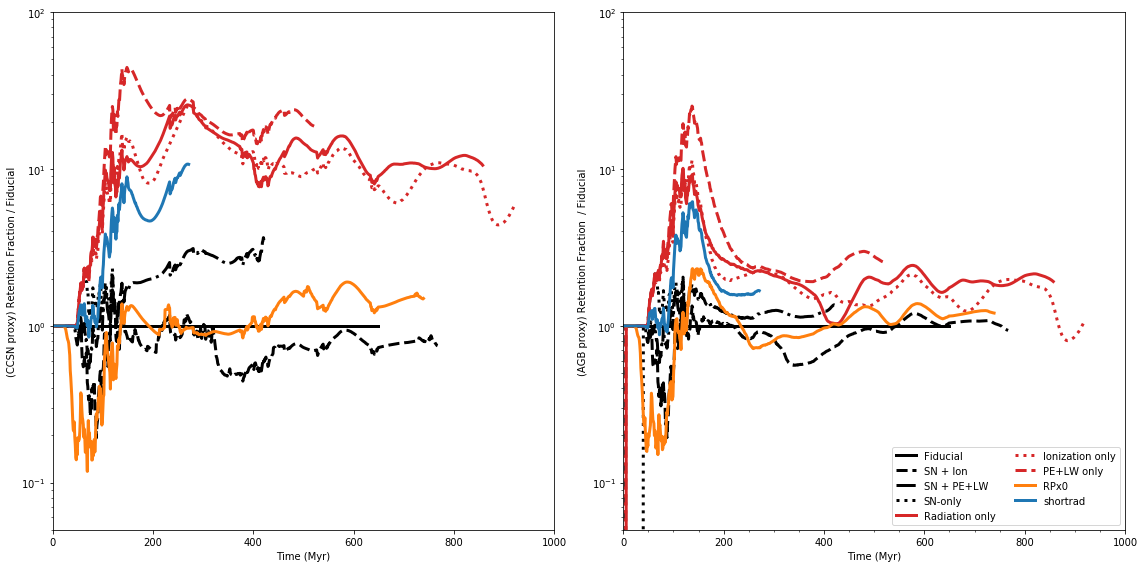

In [9]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    x_fiducial = all_data['fiducial'].data('time')
    
    t = t - t[0]
    x_fiducial = x_fiducial - x_fiducial[0]
    
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/O')
    y_fiducial = all_data['fiducial'].load_field('/gas_meta_data/masses/Disk/O')/(  
                     all_data['fiducial'].load_field('/gas_meta_data/masses/FullBox/O') +\
                     all_data['fiducial'].load_field('/gas_meta_data/masses/OutsideBox/O'))
    f_fiducial = lambda t : np.interp(t, x_fiducial, y_fiducial)
    
    
    ax[0].plot(t, ( M_disk / M_tot) / (f_fiducial(t)),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Ba')
    
    #M_disk[t < 150] = None
    
    y_fiducial = all_data['fiducial'].load_field('/gas_meta_data/masses/Disk/Ba')/(
                     all_data['fiducial'].load_field('/gas_meta_data/masses/FullBox/Ba') +\
                     all_data['fiducial'].load_field('/gas_meta_data/masses/OutsideBox/Ba'))
    
    f_fiducial = lambda t : np.interp(t, x_fiducial, y_fiducial)
    
    ax[1].plot(t, (M_disk / M_tot)/ (f_fiducial(t)),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(0.0, 1000.0)
    a.set_ylim(5.0E-2,1.0E2) #   'shortrad',
    a.semilogy()
ax[0].set_ylabel(r'(CCSN proxy) Retention Fraction / Fiducial')
ax[1].set_ylabel(r'(AGB proxy) Retention Fraction  / Fiducial')

#ax.semilogy()

ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
plt.tight_layout()
#ax.set_ylim()

fig.savefig("normalized_physics_comparison_retention.png")

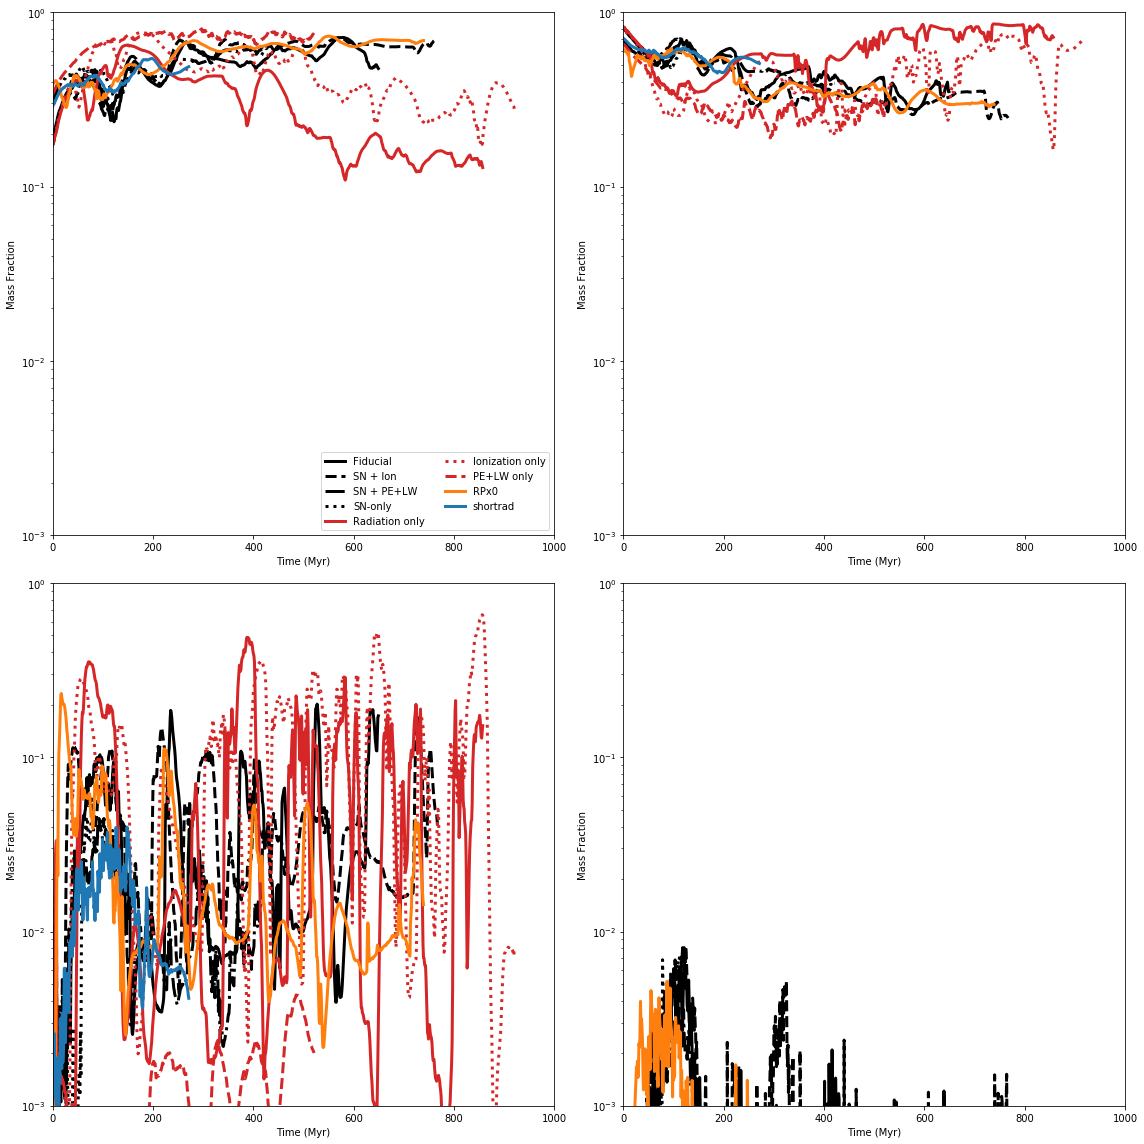

In [10]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(2,2)
fig.set_size_inches(16,16)



runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/CNM/Total')
    ax[(0,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/WNM/Total')
    ax[(0,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/WIM/Total')
    ax[(1,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])  
    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/HIM/Total')
    ax[(1,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])      

for ax1 in ax:
    for a in ax1:
        a.set_xlabel(r'Time (Myr)')
        a.set_xlim(0.0, 1000.0)
        a.set_ylim(1.0E-3, 1.0)    
        a.semilogy()
        
        a.set_ylabel(r'Mass Fraction')

#ax.semilogy()

ax[(0,0)].legend(loc='lower right',ncol = 2)

plt.tight_layout()
#ax.set_ylim()

fiducial
Failed more than 11 times loading with path /gas_meta_data/volume_fraction/Disk/Total and label /gas_meta_data/volume_fraction/Disk/Total


RuntimeError: 

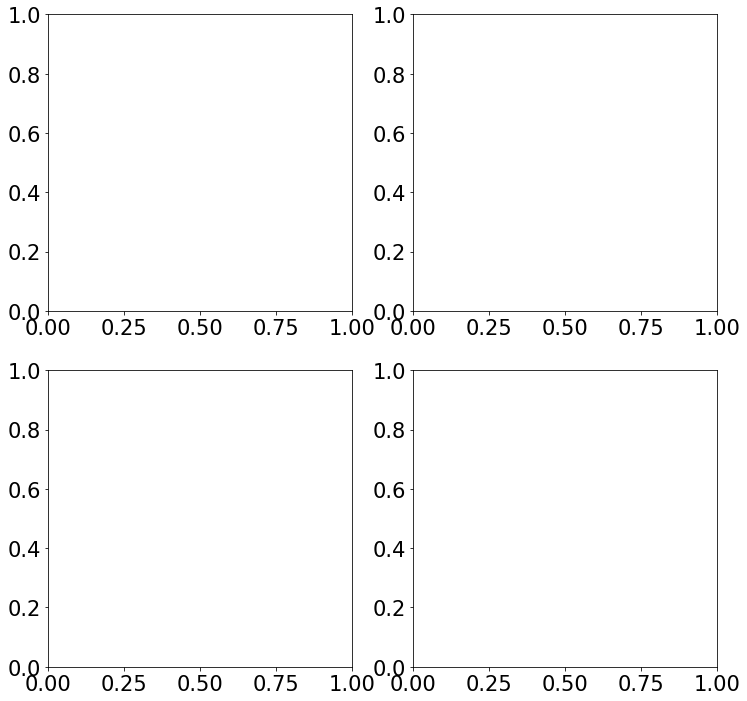

In [26]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(2,2)
fig.set_size_inches(12,12)



runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/volume_fraction/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/CNM/Total')
    ax[(0,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

    M_tot = all_data[run].load_field('/gas_meta_data/volume/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/WNM/Total')
    ax[(0,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    M_tot = all_data[run].load_field('/gas_meta_data/volume/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/WIM/Total')
    ax[(1,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])  
    M_tot = all_data[run].load_field('/gas_meta_data/volume/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/HIM/Total')
    ax[(1,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])      

for ax1 in ax:
    for a in ax1:
        a.set_xlabel(r'Time (Myr)')
        a.set_xlim(0.0, 1000.0)
        a.set_ylim(1.0E-3, 1.0)    
        a.semilogy()
        
        a.set_ylabel(r'Volume Fraction')

#ax.semilogy()

ax[(0,0)].legend(loc='lower right',ncol = 2)

plt.tight_layout()
#ax.set_ylim()

In [119]:
x = all_data['fiducial']
x.load_single??

In [125]:
all_data['fiducial'].load_single("/meta_data/",index=200)

{'M_As': 7.248672612782468e-07,
 'M_Ba': 3.1967803619442306e-07,
 'M_C': 2.46232147262666,
 'M_Ca': 0.09161082939666688,
 'M_Fe': 1.9934290679647828,
 'M_H2I': 3697.2147215787,
 'M_H2II': 0.0066620702396328986,
 'M_H2_total': 3697.2213836489395,
 'M_HI': 1096368.5042577586,
 'M_HII': 33271.63017901557,
 'M_HM': 0.0006398101773160439,
 'M_H_total': 1133337.3564602332,
 'M_HeI': 344498.1168795794,
 'M_HeII': 13097.590150329108,
 'M_HeIII': 300.30156145516054,
 'M_He_total': 357896.0085913637,
 'M_Mg': 0.6838624340139597,
 'M_Mn': 0.007536444462619772,
 'M_N': 1.5567066894282544,
 'M_Na': 0.005375591579874095,
 'M_Ni': 0.845495494284523,
 'M_O': 11.435237458395898,
 'M_S': 0.6918798961900559,
 'M_Si': 1.4252211503866743,
 'M_Sr': 3.5390549026286893e-06,
 'M_Y': 6.783311693169691e-07,
 'M_gas': 1491881.575514479,
 'M_star': 9007.586637588707,
 'SFR': 4.577129046591108e-05,
 'SFR_1': 0.0,
 'SFR_100': 4.577129046591108e-06,
 'Time': 308.00000141029,
 'Z_avg': 0.0004343636809325183,
 'dx': 3.

In [ ]:
all_data['fiducial'].load_single

TypeError: list indices must be integers or slices, not tuple

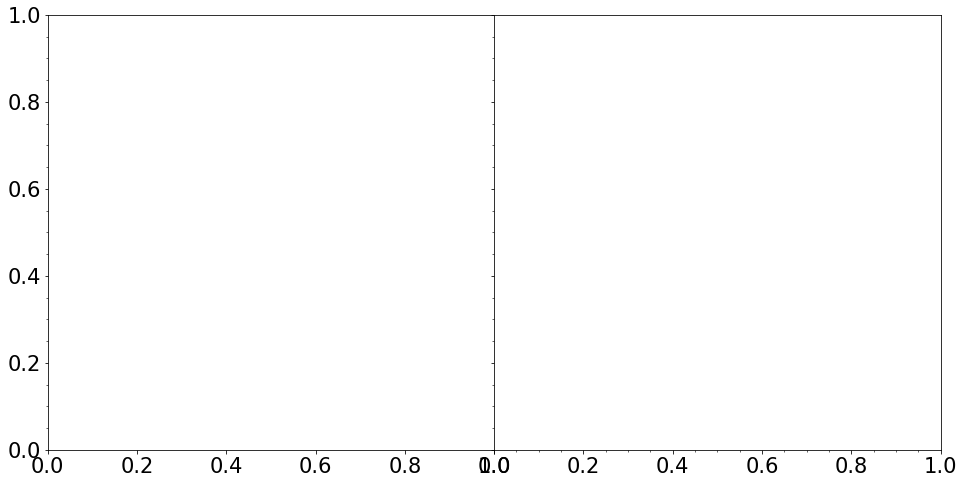

In [114]:
#
# plot a SFR comparison
#

def plot_outflow_rate(runs_to_plot = base_comparison,
                      labels_to_show1=None,labels_to_show2=None,
                      outname = "physics_comparison_outflow.png"):
    plot_settings()

    fig, ax = plt.subplots(1,2,sharey=True)
    fig.set_size_inches(16,8)

    fig.subplots_adjust(wspace=0)

    plt.minorticks_on()

    if labels_to_show1 is None:
        labels_to_show1 = ['sn_ion-no-otrad','sn_otrad_no-ion','sn_only','shortrad','fiducial']
        
    if labels_to_show2 is None:
        labels_to_show2 = ['otrad_ion-no-sn','io_no-otrad-sn','otrad_no-ion-sn','sn_otrad_ion_noRP']


    #runs_to_plot = base_comparison + ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5']
    for i,run in enumerate(runs_to_plot):
        #t = all_data[run].data('time')

        #t = t - t[0]

        # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
        t   = all_data[run].data('time')
        t = t - t[0]

        outflow = all_data[run].load_field("/gas_profiles/outflow/sphere/('gas', 'cell_mass')")

        #print(run,len(outflow), len(all_data[run].data('SFR_100')))

        SFR = 1.0 # np.average(all_data[run].data('SFR_100')[:500])

        
        if run in labels_to_show1:
            label = labels[run]
        else:
            label = None
            
        ax[0].plot(t, outflow[:,0] / SFR, # bin 0 centered on 0.1 Rvir
                label = label, lw = 3, color = colors[run], ls=lstyles[run])
        
        if run in labels_to_show2:
            label = labels[run]
        else:
            label = None
            
        ax[1].plot(t, outflow[:,3] / SFR, # bin 5 centered on Rvir
                label = label, lw = 3, color = colors[run], ls=lstyles[run])    

    for a in ax:
        a.set_xlabel(r'Time (Myr)')
        a.set_xlim(global_time_lim)
        a.set_ylim(1.0E-7,0.04) #   'shortrad',
        a.semilogy()

    #ax[0].set_ylabel(r'$\eta_M = \dot{M}_{\rm out}$ / <SFR>')

    xy=(.8,.9)
    ax[0].annotate(r"0.1 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')
    ax[1].annotate(r"1.0 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')

    ax[0].set_ylabel(r'Outflow Rate (M$_{\odot}$ yr$^{-1}$)')

    
    
    legend_prop={'size':14}
    ax[0].legend(loc='lower left',ncol=2,prop=legend_prop)
    ax[1].legend(loc='lower left',ncol=2,prop=legend_prop)
    #ax.semilogy()

    #ax[1].legend(loc='lower right',ncol = 2)
    plt.minorticks_on()
    #plt.tight_layout()
    #ax.set_ylim()

    fig.savefig(outname)
    
plot_outflow_rate(full_base_comparison, label_set_1, label_set_2)

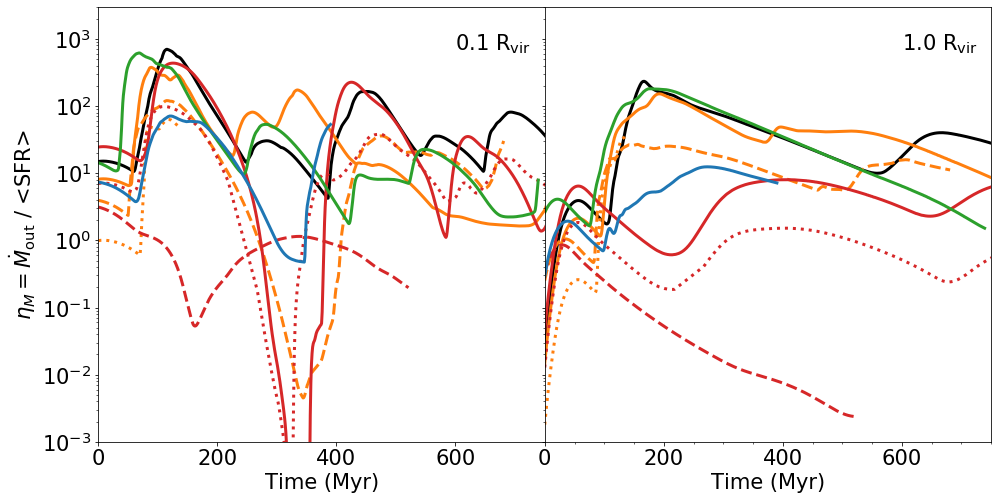

In [54]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2,sharey=True)
fig.set_size_inches(16,8)

fig.subplots_adjust(wspace=0)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    outflow = all_data[run].load_field("/gas_profiles/outflow/sphere/('gas', 'cell_mass')")
    
    #print(run,len(outflow), len(all_data[run].data('SFR_100')))

    SFR = np.average(all_data[run].data('SFR_100')[:500])
    
    ax[0].plot(t, outflow[:,0] / SFR, # bin 0 centered on 0.1 Rvir
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    ax[1].plot(t, outflow[:,3] / SFR, # bin 5 centered on Rvir
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(global_time_lim)
    a.set_ylim(0.001, 3000) #   'shortrad',
    a.semilogy()
    
ax[0].set_ylabel(r'$\eta_M = \dot{M}_{\rm out}$ / <SFR>')

xy=(.8,.9)
ax[0].annotate(r"0.1 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')
ax[1].annotate(r"1.0 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')

#ax[1].set_ylabel(r'Outflow Rate (M$_{\sun}$ yr$^{-1}$)')'

#ax.semilogy()

#ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
#plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison_outflow_loading.png")

/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log10


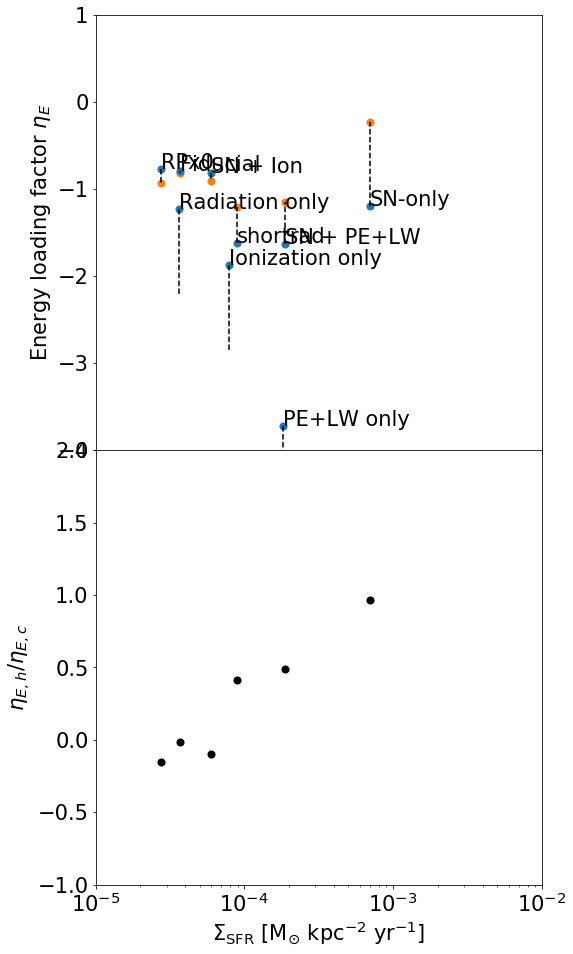

In [94]:
#
#
#
# Li + style loading tables
#
#
fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)



psize = 50
#markers = {'sn_only' : 'o',
#           'otrad_ion-no-sn' : 's',
#           'otrad_no-ion-sn' : 'D',
#           'sn_ion-no-otrad' : 'd',
           

fig, ax = plt.subplots(2,1,sharex=True)
fig.set_size_inches(8,16)
fig.subplots_adjust(hspace=0)

for run in base_comparison:
    if all_data[run].loading_table_values is None:
        continue
    x = all_data[run].loading_table_values['Sigma_sfr']
    y = np.log10(all_data[run].loading_table_values['Eta_E_hot'])
    ax[0].scatter( x,
                   y,
                   color = 'C1', s = psize, label = run, marker='o')# markers[run] )

    x = all_data[run].loading_table_values['Sigma_sfr']
    y = np.log10(all_data[run].loading_table_values['Eta_E_cold'])
    xy = (x,y)
    ax[0].scatter( x,y,
                   color = 'C0', s = psize, label = run, marker ='o')
    xy = (x,y)
    ax[0].annotate(labels[run], xy, xytext=xy, xycoords='data')    
    #ax[0].annotate(labels[run], xy, xytext=xy, xycoords='data')
    
    yline = [all_data[run].loading_table_values['Eta_E_cold'],
             all_data[run].loading_table_values['Eta_E_hot']]
    xline = [ all_data[run].loading_table_values['Sigma_sfr']]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        
        #ax[0].arrow( xline[0], yline[0], dx = 0.0, dy = yline[1] - yline[0],
        #             head_width= 0.1*xline[0],# transform=ax[0].transAxes,
        #             head_length=0.1, fc='k', ec='k')
                      
    yline = np.log10(yline)        
    #else:
        
    ax[0].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    x =all_data[run].loading_table_values['Sigma_sfr']
    y = np.log10(all_data[run].loading_table_values['Eta_E_hot_cold_ratio'])

    ax[1].scatter(x,y,
                   color = 'black', s = psize, label = run, marker ='o')
    
    #print(run, all_data[run].loading_table_values['Sigma_sfr'])
    #print(run, all_data[run].loading_table_values['Eta_E_hot'])
    #print(run, all_data[run].loading_table_values['Eta_E_cold'])
    
for a in ax:
    a.semilogx()
   # a.semilogy()
    a.set_xlim(1.0E-5,0.01)
    
ax[0].set_ylim(-4,1)
ax[1].set_ylim(-1,2)
#ax[1].legend(loc='best',ncol = 2)
ax[0].set_ylabel(r"Energy loading factor $\eta_E$")
ax[1].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
ax[1].set_ylabel(r"$\eta_{E,h} / \eta_{E,c}$")
#plt.tight_layout()
fig.savefig("phys_comparison_etaE_hot_cold_SFR.png")


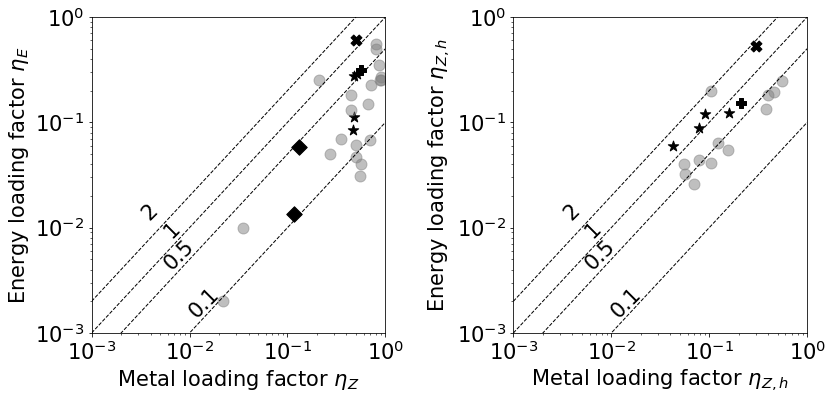

In [303]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
#fig.subplots_adjust(hspace=0)


LI = { 'Eta_Z_total' :[0.716,
0.668,
0.894,
0.44,
3.53E-01,
5.00E-01,
2.71E-01,
6.92E-01,
5.00E-01,
5.45E-01,
5.66E-01,
0.21,
0.035,
0.9,
0.8,
0.8,
0.85,
0.87,
0.45,
2.20E-02],
      'Eta_Z_hot' : [0.46,
0.376,
0.55,
0.4,
1.22E-01,
0.1563,
0.0781,
0.0554,
1.04E-01,
7.07E-02,
0.0563,
0.104],
      'Eta_E_total' : [0.224,
0.148,
0.268,
0.18,
6.87E-02,
6.10E-02,
5.02E-02,
6.77E-02,
4.69E-02,
3.09E-02,
4.05E-02,
0.25,
0.01,
0.25,
0.5,
0.55,
0.35,
0.25,
0.13,
2.00E-03],
      'Eta_E_hot' : [0.196,
0.134,
0.244,
0.18,
6.30E-02,
5.50E-02,
4.40E-02,
4.00E-02,
4.10E-02,
2.60E-02,
3.20E-02,
0.2] }

for run in base_comparison:
    if all_data[run].loading_table_values is None:
        continue
    x = all_data[run].loading_table_values['Eta_metal']
    y = all_data[run].loading_table_values['Eta_E']
        
    ax[0].scatter(x,y,color = 'black', s = psize, label = run, marker=markers[run])

    
    if all_data[run].loading_table_values is None:
        continue
    x = all_data[run].loading_table_values['Eta_metal_hot']
    y = all_data[run].loading_table_values['Eta_E_hot']
        
    ax[1].scatter(x,y,color = 'black', s = psize, label = run, marker=markers[run])

lw_2 = 1.0
    
for a in ax:

    a.set_xlim(1.0E-3,1.0)
    a.set_ylim(1.0E-3, 1.0)
    
    a.semilogy()
    a.semilogx()
    
    
    a.plot( np.array([1.0E-3,1.0]), np.array([2.0E-3,2.0]), lw = lw_2,         ls = '--',color='black')
    xy = (0.003,0.012) 
    a.text(xy[0], xy[1] , r'2', rotation = 45)    
    a.plot( [1.0E-3,1.0], [1.0E-3,1.0], lw = lw_2, ls = '--',color='black')
    xy = (0.005,0.008) 
    a.text(xy[0], xy[1] , r'1', rotation = 45)
    a.plot( [1.0E-3,1.0], [5.0E-4,0.5], lw = lw_2, ls = '--',color='black')
    xy = (0.005,0.0040) 
    a.text(xy[0], xy[1] , r'0.5', rotation = 45)    
    a.plot( [1.0E-3,1.0], [1.0E-4,0.1], lw = lw_2, ls = '--',color='black')
    xy = (0.009,0.0014) 
    a.text(xy[0], xy[1] , r'0.1', rotation = 45)      
    #a.plot( [1.0E-3,1.0], [5.0E-5,0.05], lw = lw_2, ls = '--',color='black')    

ax[0].set_xlabel("Metal loading factor $\eta_Z$")    
ax[0].set_ylabel("Energy loading factor $\eta_E$")
ax[1].set_xlabel("Metal loading factor $\eta_{Z,h}$")    
ax[1].set_ylabel("Energy loading factor $\eta_{Z,h}$")


ax[1].scatter( LI['Eta_Z_hot'], LI['Eta_E_hot'], color = 'grey', s = psize, marker = 'o', alpha = 0.5,
            label = 'Li & Bryan 2020')
ax[0].scatter( LI['Eta_Z_total'], LI['Eta_E_total'], color = 'grey', s = psize, marker = 'o', alpha = 0.5)

plt.tight_layout()
fig.savefig("phys_comparison_E_loading_Z_loading.png")

Eta_Z_total 20
Eta_Z_hot 12
Eta_E_total 20
Eta_E_hot 12


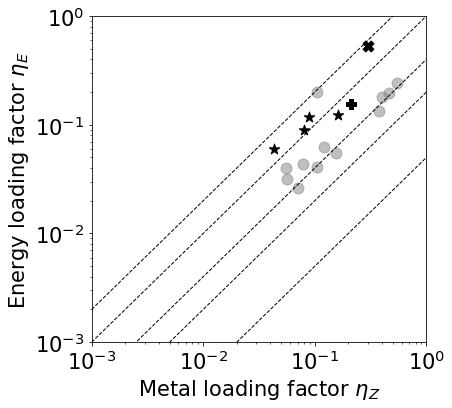

In [272]:
fig,ax = plt.subplots()
fig.set_size_inches(6,6)


xmin, xmax = 999999999,-999999999
ymin, ymax = 999999999,-999999999
for run in base_comparison:
    if all_data[run].loading_table_values is None:
        continue
    x = all_data[run].loading_table_values['Eta_metal_hot']
    y = all_data[run].loading_table_values['Eta_E_hot']
        
    ax.scatter(x,y,color = 'black', s = psize, label = run, marker=markers[run])

    xmin = np.min([x, xmin])
    xmax = np.max([x, xmax])
    ymin = np.min([y, ymin])
    ymax = np.max([y, ymax])


ax.set_ylabel("Energy loading factor $\eta_E$")
ax.set_xlabel("Metal loading factor $\eta_Z$")
ax.semilogy()
ax.semilogx()

ax.set_xlim(1.0E-3,1.0)
ax.set_ylim(1.0E-3, 1.0)

lw_2 = 1.0

ax.plot( np.array([1.0E-3,1.0]), np.array([2.0E-3,2.0]), lw = lw_2,         ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [1.0E-3,1.0], lw = lw_2, ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [4.0E-4,0.4], lw = lw_2, ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [2.0E-4,0.2], lw = lw_2, ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [5.0E-5,0.05], lw = lw_2, ls = '--',color='black')
ax.scatter( LI['Eta_Z_hot'], LI['Eta_E_hot'], color = 'grey', s = psize, marker = 'o', alpha = 0.5,
            label = 'Li & Bryan 2020')

#ax.scatter(all_data['fiducial-1.8pc'].loading_table_values['Eta_metal_hot'],
#           all_data['fiducial-1.8pc'].loading_tables_values['Eta_E_hot'], color ='C3')

fig.savefig("phys_comparison_hot_E_loading_Z_loading.png")

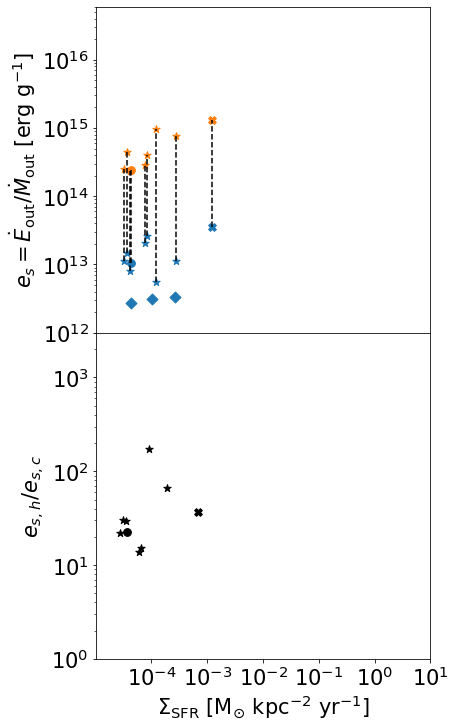

In [160]:
#
#
#
# Li + style loading tables
#
#
fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)



psize = 60
#markers = {'sn_only' : 'o',
#           'otrad_ion-no-sn' : 's',
#           'otrad_no-ion-sn' : 'D',
#            'sn_ion-no-otrad' : 'd'}

fig, ax = plt.subplots(2,1,sharex=True)
fig.set_size_inches(6,12)
fig.subplots_adjust(hspace=0)

for run in all_data.keys():
    if all_data[run].loading_table_values is None:
        continue
        
    ax[0].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['e_s_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[0].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['e_s_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])
    
    yline = [all_data[run].loading_table_values['e_s_cold'],
             all_data[run].loading_table_values['e_s_hot']]
    xline = [ all_data[run].loading_table_values['Sigma_sfr']]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        
        #ax[0].arrow( xline[0], yline[0], dx = 0.0, dy = yline[1] - yline[0],
        #             head_width= 0.1*xline[0],# transform=ax[0].transAxes,
        #             head_length=0.1, fc='k', ec='k')
                      
        
        
    #else:
        
    ax[0].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    ax[1].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['e_s_hot_cold_ratio'],
                   color = 'black', s = psize, label = run, marker = markers[run])
    
    #print(run, all_data[run].loading_table_values['Sigma_sfr'])
    #print(run, all_data[run].loading_table_values['Eta_E_hot'])
    #print(run, all_data[run].loading_table_values['Eta_E_cold'])
    
for a in ax:
    a.semilogx()
    a.semilogy()
    a.set_xlim(1.0E-5,2)
    
ax[0].set_ylim(1.0E12,6.0E16)
ax[1].set_ylim(1.0,3000.0)
#ax[1].legend(loc='best',ncol = 2)
ax[0].set_ylabel(r"$e_s = \dot{E}_{\rm out} / \dot{M}_{\rm out}$ [erg g$^{-1}$]")
ax[1].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
ax[1].set_ylabel(r"$e_{s,h} / e_{s,c}$")

ax[1].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])
plt.minorticks_on()

#plt.tight_layout()
fig.savefig("phys_comparison_e_s_hot_cold_SFR.png")


sn_ion-no-otrad 0.4347
sn_otrad_no-ion 0.35287999999999997
sn_only 0.47909999999999997
otrad_ion-no-sn 0.0698
ion_no-otrad-sn 0.09134
otrad_no-ion-sn 2.106e-11
sn_otrad_ion_noRP 0.4411
shortrad 0.132041
fiducial 0.4708


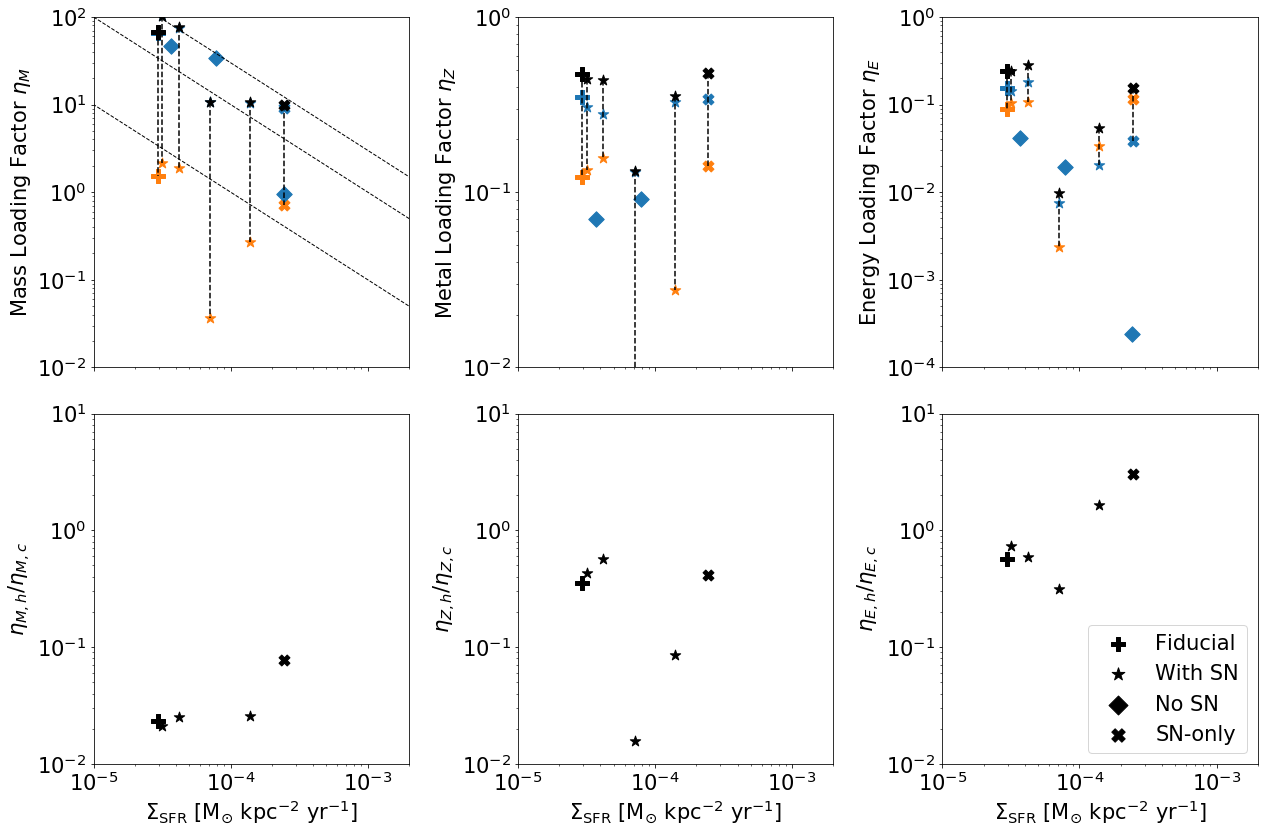

In [102]:
#
#
#
# Li + style loading tables
#
#
fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)
total_color = 'black'


psize = 120
#arkers = {'sn_only' : 'o',
#           'otrad_ion-no-sn' : 's',
#           'otrad_no-ion-sn' : 'D',
#            'sn_ion-no-otrad' : 'd'}

fig, ax = plt.subplots(2,3,sharex=True)
fig.set_size_inches(18,12)
fig.subplots_adjust(hspace=0,wspace=0.25)

sfr_dict = {}

for run in base_comparison:
    if all_data[run].loading_table_values is None:
        continue
        
    if run == 'fiducial':
        psize = 180
    else:
        psize = 120
        
    sfr_dict[run] = all_data[run].loading_table_values['Sigma_sfr']

    if run == 'otrad_no-ion-sn':
        sfr_dict[run] = sfr_dict[run]*0.9 # minor fudge for aesthetic...
    elif run == 'sn_otrad_ion_noRP':
        sfr_dict[run] = sfr_dict[run]*1.1
    
    ax[(0,0)].scatter( sfr_dict[run],
                   all_data[run].loading_table_values['Eta_mass_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[(0,0)].scatter( sfr_dict[run],
                   all_data[run].loading_table_values['Eta_mass_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])
    #ax[(0,0)].scatter( sfr_dict[run],
    #               all_data[run].loading_table_values['Eta_mass_cold'] + all_data[run].loading_table_values['Eta_mass_hot'],
    #               color = total_color, s = psize, label = run, marker = markers[run])   
    
    yline = [all_data[run].loading_table_values['Eta_mass_cold'],
             all_data[run].loading_table_values['Eta_mass_hot']]
    xline = [ sfr_dict[run]]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        #temp = ax[(0,0)].errorbar(sfr_dict[run], yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'black')
        #temp[-1][0].set_linestyle('--')
    else:
        yline[0] = yline[1] + yline[0]
        
        ax[(0,0)].scatter(sfr_dict[run],
                   all_data[run].loading_table_values['Eta_mass_cold'] + all_data[run].loading_table_values['Eta_mass_hot'],
                   color = total_color, s = psize, label = run, marker = markers[run]) 
        ax[(0,0)].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    ax[(0,1)].scatter( sfr_dict[run],
                   all_data[run].loading_table_values['Eta_metal_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[(0,1)].scatter( sfr_dict[run],
                   all_data[run].loading_table_values['Eta_metal_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])   
    #ax[(0,1)].scatter( sfr_dict[run],
    #               all_data[run].loading_table_values['Eta_metal_cold'] + all_data[run].loading_table_values['Eta_metal_hot'],
    #               color = total_color, s = psize, label = run, marker = markers[run])      
    #print(run,all_data[run].loading_table_values['Sigma_sfr'],all_data[run].loading_table_values['Eta_metal_cold'])
    yline = [all_data[run].loading_table_values['Eta_metal_cold'],
             all_data[run].loading_table_values['Eta_metal_hot']]
    xline = [ sfr_dict[run] ]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        #temp = ax[(0,1)].errorbar(sfr_dict[run], yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'black')
        #temp[-1][0].set_linestyle('--')
    else:
        yline[0] = yline[1] + yline[0]
        ax[(0,1)].scatter(sfr_dict[run],
                   all_data[run].loading_table_values['Eta_metal_cold'] + all_data[run].loading_table_values['Eta_metal_hot'],
                   color = total_color, s = psize, label = run, marker = markers[run]) 
        ax[(0,1)].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    yratio = all_data[run].loading_table_values['Eta_mass_hot'] /\
             all_data[run].loading_table_values['Eta_mass_cold']
    
    ax[(1,0)].scatter( sfr_dict[run],
                   yratio,
                   color = 'black', s = psize, label = run, marker = markers[run])
   
    print(run, all_data[run].loading_table_values['Eta_metal_cold']+all_data[run].loading_table_values['Eta_metal_hot'])

    yratio = all_data[run].loading_table_values['Eta_metal_hot'] /\
             all_data[run].loading_table_values['Eta_metal_cold']
    
    ax[(1,1)].scatter( sfr_dict[run],
                   yratio,
                   color = 'black', s = psize, label = run, marker = markers[run])
    
    #print(run, all_data[run].loading_table_values['Sigma_sfr'])
    #print(run, all_data[run].loading_table_values['Eta_E_hot'])
    #print(run, all_data[run].loading_table_values['Eta_E_cold'])
############

    x = sfr_dict[run]
    y = all_data[run].loading_table_values['Eta_E_hot']
    ax[(0,2)].scatter( x,
                   y,
                   color = 'C1', s = psize, label = run, marker=markers[run])# markers[run] )

    y = all_data[run].loading_table_values['Eta_E_cold']
    xy = (x,y)
    ax[(0,2)].scatter( x,y,
                   color = 'C0', s = psize, label = run, marker = markers[run])
    #ax[(0,2)].scatter( x , all_data[run].loading_table_values['Eta_E_hot'] +  all_data[run].loading_table_values['Eta_E_cold'],
    #               color = total_color, s = psize, label = run, marker = markers[run])    
    #xy = (x,y)
    #ax[(0,2)].annotate(labels[run], xy, xytext=xy, xycoords='data')    
    #ax[0].annotate(labels[run], xy, xytext=xy, xycoords='data')
    
    yline = [all_data[run].loading_table_values['Eta_E_cold'],
             all_data[run].loading_table_values['Eta_E_hot']]
    xline = [ sfr_dict[run] ]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        #temp = ax[(0,2)].errorbar(sfr_dict[run], yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'black')
        #temp[-1][0].set_linestyle('--')
    
    else:
        yline[1] = np.min([all_data[run].loading_table_values['Eta_E_cold'],all_data[run].loading_table_values['Eta_E_hot']])
        yline[0] = np.sum([all_data[run].loading_table_values['Eta_E_cold'],all_data[run].loading_table_values['Eta_E_hot']])
        
        ax[(0,2)].scatter(sfr_dict[run],
                   all_data[run].loading_table_values['Eta_E_cold'] + all_data[run].loading_table_values['Eta_E_hot'],
                   color = total_color, s = psize, label = run, marker = markers[run]) 
        ax[(0,2)].plot( xline,
                        yline,
                        lw = 1.5, color = 'black',
                        ls = '--')
        
        
    y = all_data[run].loading_table_values['Eta_E_hot_cold_ratio']

    ax[(1,2)].scatter(x,y,
                   color = 'black', s = psize, marker = markers[run])

# marker labels
ax[(1,2)].scatter(-1,-1,color='black',s=180, marker = 'P', label = 'Fiducial')
ax[(1,2)].scatter(-1,-1,color='black',s=psize, marker = '*', label = 'With SN')
ax[(1,2)].scatter(-1,-1,color='black',s=psize, marker = 'D', label = 'No SN')
ax[(1,2)].scatter(-1,-1,color='black',s=psize, marker = 'X', label = 'SN-only')



for a2 in ax:
    for a in a2:
        a.semilogx()
        a.semilogy()
        a.set_xlim(1.0E-5,0.002)
    
#ax[0].set_ylim(1.0E12,6.0E16)
#ax[1].set_ylim(1.0,3000.0)
#ax[1].legend(loc='best',ncol = 2)
ax[(0,0)].set_ylabel(r"Mass Loading Factor $\eta_M$")
ax[(0,1)].set_ylabel(r"Metal Loading Factor $\eta_Z$")
ax[(0,2)].set_ylabel(r"Energy Loading Factor $\eta_E$")

ax[(1,0)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
ax[(1,1)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
ax[(1,2)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")

ax[(1,0)].set_ylabel(r"$\eta_{M,h} / \eta_{M,c}$")
ax[(1,1)].set_ylabel(r"$\eta_{Z,h} / \eta_{Z,c}$")
ax[(1,2)].set_ylabel(r"$\eta_{E,h} / \eta_{E,c}$")

#ax[(1,0)].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])
#ax[(1,1)].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])

plt.minorticks_on()

ax[(0,0)].set_ylim(1.0E-2,100.0)
ax[(0,1)].set_ylim(1.0E-2,1.0)
ax[(0,2)].set_ylim(1.0E-4,1.0)

ax[(1,0)].set_ylim(0.01,10.0)
ax[(1,1)].set_ylim(0.01,10.0)
ax[(1,2)].set_ylim(0.01,10.0)

ax[(1,2)].legend(loc='lower right')


ax[(0,0)].plot([1.0E-5,1.0E-1],[100.0,0.01],lw=1,ls='--',color='black')
ax[(0,0)].plot([3.0E-5,0.3],   [100.0,0.01],lw=1,ls='--',color='black')
ax[(0,0)].plot([1.0E-6,0.01],   [100.0,0.01],lw=1,ls='--',color='black')

#ax[(0,1)].plot([1.0E-5,1.0E-1],[1.0,0.01],lw=1,ls='--',color='black')
#ax[(0,1)].plot([3.0E-5,0.3],   [1.0,0.01],lw=1,ls='--',color='black')
#ax[(0,1)].plot([1.0E-6,0.01],   [1.0,0.01],lw=1,ls='--',color='black')

plt.tight_layout()
fig.savefig("phys_comparison_mass_metal_hot_cold_SFR.png")


In [169]:
indexes = np.argsort( np.array(list( sfr_dict.values())))



for i in indexes:
    print("%30s    %5.5E"%( list(sfr_dict.keys())[i], list(sfr_dict.values())[i] ))    


                 shortrad_72pc    -9.99000E+02
                          snlw    -9.99000E+02
             sn_otrad_ion_noRP    2.76800E-05
             sn_otrad_ion_RPx2    3.11100E-05
             sn_otrad_ion_RPx5    3.48700E-05
               otrad_ion-no-sn    3.65400E-05
                      fiducial    3.67700E-05
               sn_ion-no-otrad    5.96700E-05
                          snpe    6.53200E-05
               ion_no-otrad-sn    7.89700E-05
                      shortrad    8.90400E-05
               otrad_no-ion-sn    1.83200E-04
               sn_otrad_no-ion    1.88700E-04
                       sn_only    6.95300E-04


In [250]:
markers

{'sn_only': 'X',
 'ion_no-otrad-sn': 'D',
 'otrad_ion-no-sn': 'D',
 'otrad_no-ion-sn': 'D',
 'shortrad': '*',
 'shortrad_72pc': '*',
 'sn_ion-no-otrad': '*',
 'sn_otrad_no-ion': '*',
 'snlw': '*',
 'snpe': '*',
 'sn_otrad_ion_RPx2': '*',
 'sn_otrad_ion_RPx5': '*',
 'sn_otrad_ion_noRP': '*',
 'fiducial-1.8pc': 'P',
 'fiducial': 'P'}

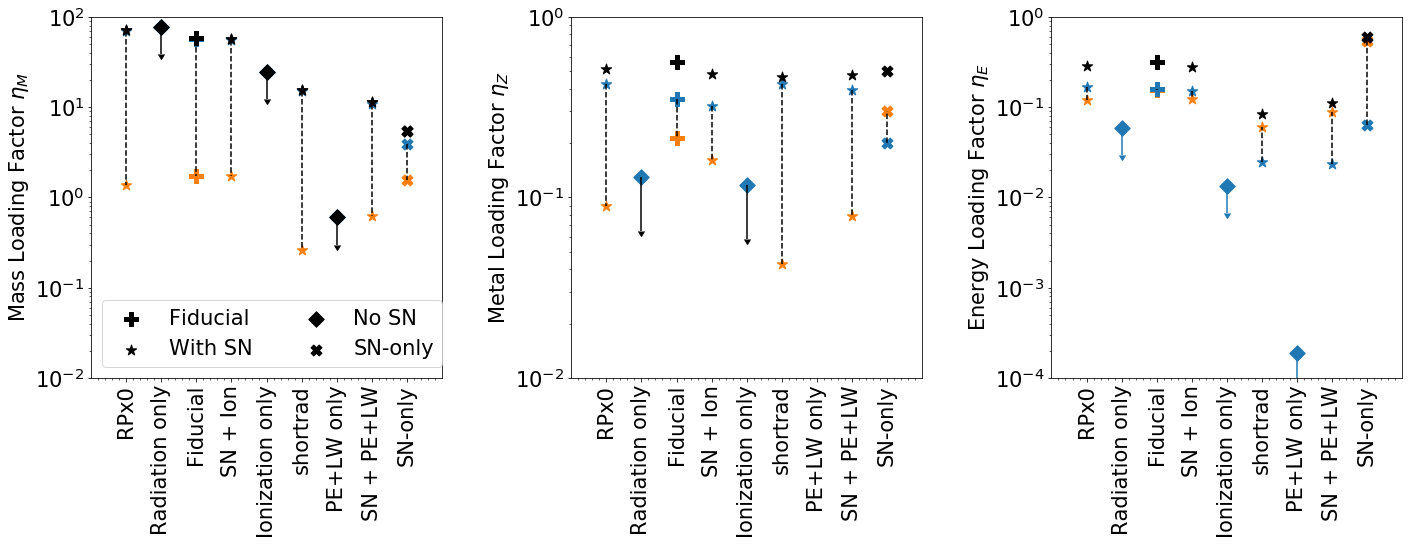

In [260]:
#
#
#
# Li + style loading tables
#
#
fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)



psize = 120
#arkers = {'sn_only' : 'o',
#           'otrad_ion-no-sn' : 's',
#           'otrad_no-ion-sn' : 'D',
#            'sn_ion-no-otrad' : 'd'}

fig, ax = plt.subplots(1,3,sharex=True)
fig.set_size_inches(20,8)
#fig.subplots_adjust(hspace=0,wspace=0.25)

sfr_dict = {}
for run in base_comparison:
    if all_data[run].loading_table_values is None:
        continue
            
    sfr_dict[run] = all_data[run].loading_table_values['Sigma_sfr']
sfr_sort= np.argsort( list(sfr_dict.values()))
i = 0
for run in np.array(list(sfr_dict.keys()))[sfr_sort]:
    if all_data[run].loading_table_values is None:
        continue
        
    if run == 'fiducial':
        psize = 180
    else:
        psize = 120
        
    xval = i
    cval = sfr_dict[run]
    

    ax[0].scatter( xval,
                   all_data[run].loading_table_values['Eta_mass_hot'],
                   color = 'C1', s = psize, marker=markers[run])
    ax[0].scatter( xval,
                   all_data[run].loading_table_values['Eta_mass_cold'],
                   color = 'C0', s = psize, marker = markers[run])
    ax[0].scatter( xval,
                   all_data[run].loading_table_values['Eta_mass_cold'] + all_data[run].loading_table_values['Eta_mass_hot'],
                   color = total_color, s = psize,  marker = markers[run])   
    
    yline = [all_data[run].loading_table_values['Eta_mass_cold'],
             all_data[run].loading_table_values['Eta_mass_hot']]
    xline = [ xval]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        temp = ax[0].errorbar(xval, yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'black')
        temp[-1][0].set_linestyle('--')
    else:
        ax[0].scatter(xval,
                   all_data[run].loading_table_values['Eta_mass_cold'] + all_data[run].loading_table_values['Eta_mass_hot'],
                   color = total_color, s = psize, marker = markers[run]) 
        ax[0].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    ax[1].scatter( xval,
                   all_data[run].loading_table_values['Eta_metal_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[1].scatter( xval,
                   all_data[run].loading_table_values['Eta_metal_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])   
     
    #print(run,all_data[run].loading_table_values['Sigma_sfr'],all_data[run].loading_table_values['Eta_metal_cold'])
    yline = [all_data[run].loading_table_values['Eta_metal_cold'],
             all_data[run].loading_table_values['Eta_metal_hot']]
    xline = [ xval]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        temp = ax[1].errorbar(xval, yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'black')
        temp[-1][0].set_linestyle('--')
    else:
        ax[1].scatter(xval,
                   all_data[run].loading_table_values['Eta_metal_cold'] + all_data[run].loading_table_values['Eta_metal_hot'],
                   color = total_color, s = psize, label = run, marker = markers[run]) 
        ax[1].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
############

    y = all_data[run].loading_table_values['Eta_E_hot']
    ax[2].scatter( xval,
                   y,
                   color = 'C1', s = psize, marker=markers[run])# markers[run] )

    x = all_data[run].loading_table_values['Sigma_sfr']
    y = all_data[run].loading_table_values['Eta_E_cold']
    xy = (x,y)
    ax[2].scatter( xval,y,
                   color = 'C0', s = psize, marker = markers[run])

    #xy = (x,y)
    #ax[(0,2)].annotate(labels[run], xy, xytext=xy, xycoords='data')    
    #ax[0].annotate(labels[run], xy, xytext=xy, xycoords='data')
    
    yline = [all_data[run].loading_table_values['Eta_E_cold'],
             all_data[run].loading_table_values['Eta_E_hot']]
    xline = [ xval]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        
        #ax[0].arrow( xline[0], yline[0], dx = 0.0, dy = yline[1] - yline[0],
        #             head_width= 0.1*xline[0],# transform=ax[0].transAxes,
        #             head_length=0.1, fc='k', ec='k')
        
        temp = ax[2].errorbar(xval, yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'C0')
        temp[-1][0].set_linestyle('--')
                      
    else:

    
        ax[2].scatter(xval, all_data[run].loading_table_values['Eta_E_hot'] + all_data[run].loading_table_values['Eta_E_cold'],
                  color = total_color, s = psize,marker = markers[run])        
        ax[2].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    i = i + 1


# marker labels
ax[0].scatter(-1,-1,color='black',s=180, marker = 'P', label = 'Fiducial')
ax[0].scatter(-1,-1,color='black',s=psize, marker = '*', label = 'With SN')
ax[0].scatter(-1,-1,color='black',s=psize, marker = 'D', label = 'No SN')
ax[0].scatter(-1,-1,color='black',s=psize, marker = 'X', label = 'SN-only')


xticklabels = [labels[run] for run in np.array( list(sfr_dict.keys()))[sfr_sort]]

for a in ax:
    a.semilogy()
    a.set_xlim(-1,i)
    a.set_xticks(np.arange(0,i))
    a.set_xticklabels(xticklabels, rotation='vertical')
    
#ax[0].set_ylim(1.0E12,6.0E16)
#ax[1].set_ylim(1.0,3000.0)
#ax[1].legend(loc='best',ncol = 2)
ax[0].set_ylabel(r"Mass Loading Factor $\eta_M$")
ax[1].set_ylabel(r"Metal Loading Factor $\eta_Z$")
ax[2].set_ylabel(r"Energy Loading Factor $\eta_E$")

#ax[(1,0)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
#ax[(1,1)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
#ax[(1,2)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")

#ax[(1,0)].set_ylabel(r"$\eta_{M,h} / \eta_{M,c}$")
#ax[(1,1)].set_ylabel(r"$\eta_{Z,h} / \eta_{Z,c}$")
#ax[(1,2)].set_ylabel(r"$\eta_{E,h} / \eta_{E,c}$")

#ax[(1,0)].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])
#ax[(1,1)].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])

plt.minorticks_on()

ax[0].set_ylim(1.0E-2,100.0)
ax[1].set_ylim(1.0E-2,1.0)
ax[2].set_ylim(1.0E-4,1.0)

ax[0].legend(loc='lower left',ncol=2)


plt.tight_layout()
fig.savefig("phys_comparison_bar_mass_metal_hot_cold_SFR.png")


In [101]:
plot_settings()

fs = 4

show_axis = False

def plot_image_panel(time,axis):

    fig, ax = plt.subplots(3,3, sharex=True, sharey=True)
    fig.set_size_inches(fs*3,fs*3)
    #fig.subplots_adjust(wspace=0,hspace=0)
    fig.subplots_adjust(bottom=0.01, top=0.99, left=0.01, right=0.95,
                    wspace=0.0, hspace=0.00)
    #
    # plot many panel phase diagram
    #


    runs = ['fiducial', 'sn_otrad_no-ion', 'sn_ion-no-otrad',
            'shortrad', 'sn_only', 'sn_otrad_ion_noRP',
            'otrad_ion-no-sn', 'otrad_no-ion-sn', 'ion_no-otrad-sn']

    image_type = 'proj'
    xlim = [-2.5,2.5]
    ylim = [2.5, 2.5]
    #phase_type = "nT_phase_outside_disk"
    im = None

    axi,axj=0,0
    for i,run in enumerate(runs):
        axindex = (axi,axj)


        if show_axis:
            if axi == 2:
                ax[axindex].set_xlabel(r"x (kpc)")
                ax[axindex].set_xticks([-1.0,-0.5,0,0.5,1.0])        
               

            if axj == 0:
                ax[axindex].set_ylabel(r"y (kpc)")
                ax[axindex].set_yticks([-1.0,-0.5,0,0.5,1.0])
             
            else:
                ax[axindex].set_yticks([])
            #ax[axindex].set_yticks([1,2,3,4,5,6,7])
            ax[axindex].set_yticks([-1.0,-0.5,0,0.5,1.0])
        else:
            ax[axindex].set_xticks([])
            ax[axindex].set_yticks([])
           


        # iterate for now to work woth continue
        axj = axj + 1
        if axj >= 3:
            axj = 0
            axi = axi + 1
        xy = (0.025,0.025)
        ax[axindex].annotate( labels[run], xy=xy,xycoords='axes fraction', color='white')
        
        image_data = all_data[run].load_image(time, "('gas', 'number_density')",axis, "proj")

        if image_data is None:
            print("Missing data for run ", run)
            
            continue
            
        if axindex[1] == 2 and axindex[0] == 2:
            xy = (0.025, 0.925)
            ax[axindex].annotate("250 pc", xy =xy, xycoords='axes fraction', color = 'white')
            shift = 0.1
            ax[axindex].plot([-1.125+shift,-0.875+shift],[0.98,0.98], lw = 4, color = 'white')



        im = ax[axindex].imshow(image_data, cmap = 'viridis', norm = LogNorm(),
                                vmin = 2.0E-4, vmax = 100.0,                                
                                extent=[-1.25,1.25,-1.25,1.25])
        

                                     #vmin=np.log10(0.01), vmax = np.log10(6.0E4))

        #ax[axindex].annotate(xy,xytext=)
        #ax[axindex].semilogx()
        #ax[axindex].semilogy()
        ax[axindex].set_xlim(-1.25,1.25)
        ax[axindex].set_ylim(-1.25,1.25)
        #ax[axindex].set_ylim(0,7)
        #if axindex[0] == 2:
        #    ax[axindex].xaxis.set_xticks(np.arange(-2.5,3.0,0.5))
        


        if False:
            if axindex[1] == 2:
                divider = make_axes_locatable(ax[axindex])
                cax     = divider.append_axes("right", size="4%", pad=0.0)    


                c = fig.colorbar(im, cax=cax)
                c.set_label(r"Number Density (cm$^{-3}$)")
                

        plt.minorticks_on()
    
    cb_ax = fig.add_axes([0.95, 0.02, 0.01, 0.97])
    if not (im is None):
        cbar = fig.colorbar(im, cax=cb_ax)

 #set the colorbar ticks and tick labels
    #cbar.set_ticks(np.arange(0, 1.1, 0.5))
        cbar.set_label(r"Number Density (cm$^{-3}$)")
    
    
    fig.savefig("proj_panel_2/proj_plot_n_" + axis + "_" + "%03i"%(time) + ".png", bbox_inches="tight")

    plt.close()
    return

for i in np.arange(0,700,5):
    plot_image_panel(i,'z')
    plot_image_panel(i,'x')    

Cannot find ds DD0094 or one +/- 1 away 94 fiducial
Missing data for run  fiducial
Cannot find ds DD0094 or one +/- 1 away 94 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0094 or one +/- 1 away 94 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0094 or one +/- 1 away 94 shortrad
Missing data for run  shortrad
Cannot find ds DD0094 or one +/- 1 away 94 sn_only
Missing data for run  sn_only
Cannot find ds DD0094 or one +/- 1 away 94 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0094 or one +/- 1 away 94 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0094 or one +/- 1 away 94 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0094 or one +/- 1 away 94 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0094 or one +/- 1 away 94 fiducial
Missing data for run  fiducial
Cannot find ds DD0094 or one +/- 1 away 94 sn_otrad_no-ion
Missing data for run  sn_

Cannot find ds DD0119 or one +/- 1 away 119 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0119 or one +/- 1 away 119 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0124 or one +/- 1 away 124 fiducial
Missing data for run  fiducial
Cannot find ds DD0124 or one +/- 1 away 124 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0124 or one +/- 1 away 124 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0124 or one +/- 1 away 124 shortrad
Missing data for run  shortrad
Cannot find ds DD0124 or one +/- 1 away 124 sn_only
Missing data for run  sn_only
Cannot find ds DD0124 or one +/- 1 away 124 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0124 or one +/- 1 away 124 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0124 or one +/- 1 away 124 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0124 or one +/- 1 away 124 ion_no-otrad-sn


Missing data for run  sn_only
Cannot find ds DD0149 or one +/- 1 away 149 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0149 or one +/- 1 away 149 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0149 or one +/- 1 away 149 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0149 or one +/- 1 away 149 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0154 or one +/- 1 away 154 fiducial
Missing data for run  fiducial
Cannot find ds DD0154 or one +/- 1 away 154 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0154 or one +/- 1 away 154 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0154 or one +/- 1 away 154 shortrad
Missing data for run  shortrad
Cannot find ds DD0154 or one +/- 1 away 154 sn_only
Missing data for run  sn_only
Cannot find ds DD0154 or one +/- 1 away 154 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0154 or o

Cannot find ds DD0179 or one +/- 1 away 179 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0179 or one +/- 1 away 179 shortrad
Missing data for run  shortrad
Cannot find ds DD0179 or one +/- 1 away 179 sn_only
Missing data for run  sn_only
Cannot find ds DD0179 or one +/- 1 away 179 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0179 or one +/- 1 away 179 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0179 or one +/- 1 away 179 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0179 or one +/- 1 away 179 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0184 or one +/- 1 away 184 fiducial
Missing data for run  fiducial
Cannot find ds DD0184 or one +/- 1 away 184 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0184 or one +/- 1 away 184 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0184 or one +/- 1 away 184 shortrad
Missing

Cannot find ds DD0209 or one +/- 1 away 209 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0209 or one +/- 1 away 209 fiducial
Missing data for run  fiducial
Cannot find ds DD0209 or one +/- 1 away 209 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0209 or one +/- 1 away 209 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0209 or one +/- 1 away 209 shortrad
Missing data for run  shortrad
Cannot find ds DD0209 or one +/- 1 away 209 sn_only
Missing data for run  sn_only
Cannot find ds DD0209 or one +/- 1 away 209 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0209 or one +/- 1 away 209 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0209 or one +/- 1 away 209 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0209 or one +/- 1 away 209 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0214 or one +/- 1 away 214 fiducial
Missing

Cannot find ds DD0244 or one +/- 1 away 244 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0244 or one +/- 1 away 244 shortrad
Missing data for run  shortrad
Cannot find ds DD0244 or one +/- 1 away 244 sn_only
Missing data for run  sn_only
Cannot find ds DD0244 or one +/- 1 away 244 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0244 or one +/- 1 away 244 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0244 or one +/- 1 away 244 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0244 or one +/- 1 away 244 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0244 or one +/- 1 away 244 fiducial
Missing data for run  fiducial
Cannot find ds DD0244 or one +/- 1 away 244 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0244 or one +/- 1 away 244 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0244 or one +/- 1 away 244 shortrad
Missing

Missing data for run  otrad_ion-no-sn
Cannot find ds DD0269 or one +/- 1 away 269 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0269 or one +/- 1 away 269 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0274 or one +/- 1 away 274 fiducial
Missing data for run  fiducial
Cannot find ds DD0274 or one +/- 1 away 274 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0274 or one +/- 1 away 274 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0274 or one +/- 1 away 274 shortrad
Missing data for run  shortrad
Cannot find ds DD0274 or one +/- 1 away 274 sn_only
Missing data for run  sn_only
Cannot find ds DD0274 or one +/- 1 away 274 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0274 or one +/- 1 away 274 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0274 or one +/- 1 away 274 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0274 

Cannot find ds DD0299 or one +/- 1 away 299 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0299 or one +/- 1 away 299 shortrad
Missing data for run  shortrad
Cannot find ds DD0299 or one +/- 1 away 299 sn_only
Missing data for run  sn_only
Cannot find ds DD0299 or one +/- 1 away 299 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0299 or one +/- 1 away 299 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0299 or one +/- 1 away 299 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0299 or one +/- 1 away 299 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0304 or one +/- 1 away 304 fiducial
Missing data for run  fiducial
Cannot find ds DD0304 or one +/- 1 away 304 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0304 or one +/- 1 away 304 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0304 or one +/- 1 away 304 shortrad
Missing

Missing data for run  otrad_ion-no-sn
Cannot find ds DD0329 or one +/- 1 away 329 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0329 or one +/- 1 away 329 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0329 or one +/- 1 away 329 fiducial
Missing data for run  fiducial
Cannot find ds DD0329 or one +/- 1 away 329 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0329 or one +/- 1 away 329 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0329 or one +/- 1 away 329 shortrad
Missing data for run  shortrad
Cannot find ds DD0329 or one +/- 1 away 329 sn_only
Missing data for run  sn_only
Cannot find ds DD0329 or one +/- 1 away 329 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0329 or one +/- 1 away 329 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0329 or one +/- 1 away 329 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0329 

Cannot find ds DD0359 or one +/- 1 away 359 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0359 or one +/- 1 away 359 shortrad
Missing data for run  shortrad
Cannot find ds DD0359 or one +/- 1 away 359 sn_only
Missing data for run  sn_only
Cannot find ds DD0359 or one +/- 1 away 359 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0359 or one +/- 1 away 359 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0359 or one +/- 1 away 359 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0359 or one +/- 1 away 359 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0359 or one +/- 1 away 359 fiducial
Missing data for run  fiducial
Cannot find ds DD0359 or one +/- 1 away 359 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0359 or one +/- 1 away 359 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0359 or one +/- 1 away 359 shortrad
Missing

Missing data for run  otrad_ion-no-sn
Cannot find ds DD0384 or one +/- 1 away 384 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0384 or one +/- 1 away 384 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0389 or one +/- 1 away 389 sn_only
Missing data for run  sn_only
Cannot find ds DD0389 or one +/- 1 away 389 sn_only
Missing data for run  sn_only
Cannot find ds DD0394 or one +/- 1 away 394 fiducial
Missing data for run  fiducial
Cannot find ds DD0394 or one +/- 1 away 394 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0394 or one +/- 1 away 394 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0394 or one +/- 1 away 394 shortrad
Missing data for run  shortrad
Cannot find ds DD0394 or one +/- 1 away 394 sn_only
Missing data for run  sn_only
Cannot find ds DD0394 or one +/- 1 away 394 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0394 or one +/- 1 away 394 otrad_ion-

Missing data for run  fiducial
Cannot find ds DD0419 or one +/- 1 away 419 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0419 or one +/- 1 away 419 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0419 or one +/- 1 away 419 shortrad
Missing data for run  shortrad
Cannot find ds DD0419 or one +/- 1 away 419 sn_only
Missing data for run  sn_only
Cannot find ds DD0419 or one +/- 1 away 419 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0419 or one +/- 1 away 419 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0419 or one +/- 1 away 419 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0419 or one +/- 1 away 419 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0424 or one +/- 1 away 424 fiducial
Missing data for run  fiducial
Cannot find ds DD0424 or one +/- 1 away 424 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0424 or one 

Cannot find ds DD0449 or one +/- 1 away 449 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0449 or one +/- 1 away 449 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0449 or one +/- 1 away 449 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0449 or one +/- 1 away 449 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0449 or one +/- 1 away 449 fiducial
Missing data for run  fiducial
Cannot find ds DD0449 or one +/- 1 away 449 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0449 or one +/- 1 away 449 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0449 or one +/- 1 away 449 shortrad
Missing data for run  shortrad
Cannot find ds DD0449 or one +/- 1 away 449 sn_only
Missing data for run  sn_only
Cannot find ds DD0449 or one +/- 1 away 449 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0449 or one +/- 1 away 449 otrad_ion-no

Cannot find ds DD0474 or one +/- 1 away 474 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0474 or one +/- 1 away 474 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0479 or one +/- 1 away 479 fiducial
Missing data for run  fiducial
Cannot find ds DD0479 or one +/- 1 away 479 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0479 or one +/- 1 away 479 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0479 or one +/- 1 away 479 shortrad
Missing data for run  shortrad
Cannot find ds DD0479 or one +/- 1 away 479 sn_only
Missing data for run  sn_only
Cannot find ds DD0479 or one +/- 1 away 479 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0479 or one +/- 1 away 479 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0479 or one +/- 1 away 479 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0479 or one +/- 1 away 479 ion_no-otrad-sn


Missing data for run  fiducial
Cannot find ds DD0504 or one +/- 1 away 504 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0504 or one +/- 1 away 504 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0504 or one +/- 1 away 504 shortrad
Missing data for run  shortrad
Cannot find ds DD0504 or one +/- 1 away 504 sn_only
Missing data for run  sn_only
Cannot find ds DD0504 or one +/- 1 away 504 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0504 or one +/- 1 away 504 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0504 or one +/- 1 away 504 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0504 or one +/- 1 away 504 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0509 or one +/- 1 away 509 fiducial
Missing data for run  fiducial
Cannot find ds DD0509 or one +/- 1 away 509 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0509 or one 

Cannot find ds DD0534 or one +/- 1 away 534 shortrad
Missing data for run  shortrad
Cannot find ds DD0534 or one +/- 1 away 534 sn_only
Missing data for run  sn_only
Cannot find ds DD0534 or one +/- 1 away 534 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0534 or one +/- 1 away 534 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0534 or one +/- 1 away 534 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0534 or one +/- 1 away 534 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0534 or one +/- 1 away 534 fiducial
Missing data for run  fiducial
Cannot find ds DD0534 or one +/- 1 away 534 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0534 or one +/- 1 away 534 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0534 or one +/- 1 away 534 shortrad
Missing data for run  shortrad
Cannot find ds DD0534 or one +/- 1 away 534 sn_only
Missing data for run  

Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0559 or one +/- 1 away 559 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0559 or one +/- 1 away 559 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0559 or one +/- 1 away 559 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0564 or one +/- 1 away 564 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0564 or one +/- 1 away 564 sn_only
Missing data for run  sn_only
Cannot find ds DD0564 or one +/- 1 away 564 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0564 or one +/- 1 away 564 sn_only
Missing data for run  sn_only
Cannot find ds DD0569 or one +/- 1 away 569 fiducial
Missing data for run  fiducial
Cannot find ds DD0569 or one +/- 1 away 569 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0569 or one +/- 1 away 569 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0569 or o

Cannot find ds DD0594 or one +/- 1 away 594 sn_only
Missing data for run  sn_only
Cannot find ds DD0594 or one +/- 1 away 594 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0594 or one +/- 1 away 594 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0594 or one +/- 1 away 594 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0594 or one +/- 1 away 594 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0594 or one +/- 1 away 594 fiducial
Missing data for run  fiducial
Cannot find ds DD0594 or one +/- 1 away 594 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0594 or one +/- 1 away 594 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0594 or one +/- 1 away 594 shortrad
Missing data for run  shortrad
Cannot find ds DD0594 or one +/- 1 away 594 sn_only
Missing data for run  sn_only
Cannot find ds DD0594 or one +/- 1 away 594 sn_otrad_ion_noRP
Missing data f

Cannot find ds DD0619 or one +/- 1 away 619 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0619 or one +/- 1 away 619 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0619 or one +/- 1 away 619 shortrad
Missing data for run  shortrad
Cannot find ds DD0619 or one +/- 1 away 619 sn_only
Missing data for run  sn_only
Cannot find ds DD0619 or one +/- 1 away 619 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0619 or one +/- 1 away 619 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0619 or one +/- 1 away 619 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0619 or one +/- 1 away 619 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0619 or one +/- 1 away 619 fiducial
Missing data for run  fiducial
Cannot find ds DD0619 or one +/- 1 away 619 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0619 or one +/- 1 away 619 sn_ion-no-otrad


Cannot find ds DD0639 or one +/- 1 away 639 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0639 or one +/- 1 away 639 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0644 or one +/- 1 away 644 fiducial
Missing data for run  fiducial
Cannot find ds DD0644 or one +/- 1 away 644 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0644 or one +/- 1 away 644 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0644 or one +/- 1 away 644 shortrad
Missing data for run  shortrad
Cannot find ds DD0644 or one +/- 1 away 644 sn_only
Missing data for run  sn_only
Cannot find ds DD0644 or one +/- 1 away 644 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0644 or one +/- 1 away 644 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0644 or one +/- 1 away 644 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0644 or one +/- 1 away 644 ion_no-otrad-sn


Missing data for run  sn_only
Cannot find ds DD0664 or one +/- 1 away 664 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0664 or one +/- 1 away 664 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0664 or one +/- 1 away 664 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0664 or one +/- 1 away 664 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0669 or one +/- 1 away 669 fiducial
Missing data for run  fiducial
Cannot find ds DD0669 or one +/- 1 away 669 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0669 or one +/- 1 away 669 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0669 or one +/- 1 away 669 shortrad
Missing data for run  shortrad
Cannot find ds DD0669 or one +/- 1 away 669 sn_only
Missing data for run  sn_only
Cannot find ds DD0669 or one +/- 1 away 669 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0669 or o

Cannot find ds DD0689 or one +/- 1 away 689 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0689 or one +/- 1 away 689 shortrad
Missing data for run  shortrad
Cannot find ds DD0689 or one +/- 1 away 689 sn_only
Missing data for run  sn_only
Cannot find ds DD0689 or one +/- 1 away 689 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0689 or one +/- 1 away 689 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0689 or one +/- 1 away 689 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0689 or one +/- 1 away 689 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0694 or one +/- 1 away 694 fiducial
Missing data for run  fiducial
Cannot find ds DD0694 or one +/- 1 away 694 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0694 or one +/- 1 away 694 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0694 or one +/- 1 away 694 shortrad
Missing

Cannot find ds DD0714 or one +/- 1 away 714 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0714 or one +/- 1 away 714 fiducial
Missing data for run  fiducial
Cannot find ds DD0714 or one +/- 1 away 714 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0714 or one +/- 1 away 714 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0714 or one +/- 1 away 714 shortrad
Missing data for run  shortrad
Cannot find ds DD0714 or one +/- 1 away 714 sn_only
Missing data for run  sn_only
Cannot find ds DD0714 or one +/- 1 away 714 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0714 or one +/- 1 away 714 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0714 or one +/- 1 away 714 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0714 or one +/- 1 away 714 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0719 or one +/- 1 away 719 fiducial
Missing

Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0739 or one +/- 1 away 739 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0739 or one +/- 1 away 739 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0739 or one +/- 1 away 739 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0739 or one +/- 1 away 739 fiducial
Missing data for run  fiducial
Cannot find ds DD0739 or one +/- 1 away 739 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0739 or one +/- 1 away 739 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0739 or one +/- 1 away 739 shortrad
Missing data for run  shortrad
Cannot find ds DD0739 or one +/- 1 away 739 sn_only
Missing data for run  sn_only
Cannot find ds DD0739 or one +/- 1 away 739 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0739 or one +/- 1 away 739 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD073

Cannot find ds DD0764 or one +/- 1 away 764 shortrad
Missing data for run  shortrad
Cannot find ds DD0764 or one +/- 1 away 764 sn_only
Missing data for run  sn_only
Cannot find ds DD0764 or one +/- 1 away 764 sn_otrad_ion_noRP
Missing data for run  sn_otrad_ion_noRP
Cannot find ds DD0764 or one +/- 1 away 764 otrad_ion-no-sn
Missing data for run  otrad_ion-no-sn
Cannot find ds DD0764 or one +/- 1 away 764 otrad_no-ion-sn
Missing data for run  otrad_no-ion-sn
Cannot find ds DD0764 or one +/- 1 away 764 ion_no-otrad-sn
Missing data for run  ion_no-otrad-sn
Cannot find ds DD0764 or one +/- 1 away 764 fiducial
Missing data for run  fiducial
Cannot find ds DD0764 or one +/- 1 away 764 sn_otrad_no-ion
Missing data for run  sn_otrad_no-ion
Cannot find ds DD0764 or one +/- 1 away 764 sn_ion-no-otrad
Missing data for run  sn_ion-no-otrad
Cannot find ds DD0764 or one +/- 1 away 764 shortrad
Missing data for run  shortrad
Cannot find ds DD0764 or one +/- 1 away 764 sn_only
Missing data for run  

In [38]:
plot_settings()

fs = 5

show_axis = False

temp_labels = {'fiducial':'Fiducial','sn_otrad_no-ion':'No Ionizing Radiation','otrad_ion-no-sn':'Radiation Only'}

def plot_image_panel(time,axis, runs=None):
    nrow,ncol=1,3
    fig, ax = plt.subplots(nrow,ncol, sharex=True, sharey=True)
    fig.set_size_inches(fs*ncol,fs*nrow)
    #fig.subplots_adjust(wspace=0,hspace=0)
    fig.subplots_adjust(bottom=0.01, top=0.99, left=0.01, right=0.95,
                    wspace=0.0, hspace=0.00)
    #
    # plot many panel phase diagram
    #

    if runs is None:
        runs = ['fiducial', 'sn_otrad_no-ion', 'sn_ion-no-otrad',
            'shortrad', 'sn_only', 'sn_otrad_ion_noRP',
            'otrad_ion-no-sn', 'otrad_no-ion-sn', 'ion_no-otrad-sn']

    image_type = 'proj'
    xlim = [-2.5,2.5]
    ylim = [2.5, 2.5]
    #phase_type = "nT_phase_outside_disk"


    axi,axj=0,0
    for i,run in enumerate(runs):
        
        if nrow == 1:
            axindex = axj
        else:
            axindex = (axi,axj)


        if show_axis:
            if axi == 2:
                ax[axindex].set_xlabel(r"x (kpc)")
                ax[axindex].set_xticks([-1.0,-0.5,0,0.5,1.0])        
               

            if axj == 0:
                ax[axindex].set_ylabel(r"y (kpc)")
                ax[axindex].set_yticks([-1.0,-0.5,0,0.5,1.0])
             
            else:
                ax[axindex].set_yticks([])
            #ax[axindex].set_yticks([1,2,3,4,5,6,7])
            ax[axindex].set_yticks([-1.0,-0.5,0,0.5,1.0])
        else:
            ax[axindex].set_xticks([])
            ax[axindex].set_yticks([])
           


        # iterate for now to work woth continue
        axj = axj + 1
        if axj >= 3:
            axj = 0
            axi = axi + 1
        xy = (0.025,0.025)
        ax[axindex].annotate( temp_labels[run], xy=xy,xycoords='axes fraction', color='white')
        
        annotate_this_one = False
        if np.size(axindex) > 1:
            if axindex[1] == 2 and axindex[0] == 2:
                annotate_this_one = True
        elif axindex == ncol-1:
            annotate_this_one=True
            
        if annotate_this_one:
            xy = (0.025, 0.925)
            ax[axindex].annotate("250 pc", xy =xy, xycoords='axes fraction', color = 'white')
            shift = 0.1
            ax[axindex].plot([-1.125+shift,-0.875+shift],[0.98,0.98], lw = 4, color = 'white')
            
        annotate_this_one = False
        if np.size(axindex) > 1:
            if axindex[1] == 0 and axindex[0] == 0:
                annotate_this_one = True
        elif axindex == 0:
            annotate_this_one=True
            
        if annotate_this_one:
            
            xy = (0.025, 0.925)
            ax[axindex].annotate("%5.1f Myr"%(time), xy =xy, xycoords='axes fraction', color = 'white')
        #    shift = 0.1
        #    ax[axindex].plot([-1.125+shift,-0.875+shift],[0.98,0.98], lw = 4, color = 'white')
                        
            
            
        image_data = all_data[run].load_image(time, "('gas', 'number_density')",axis, "proj")

        if image_data is None:
            print("Missing data for run ", run)
            continue

        im = ax[axindex].imshow(image_data, cmap = 'viridis', norm = LogNorm(),
                                vmin = 2.0E-4, vmax = 100.0,
                                extent=[-1.25,1.25,-1.25,1.25])
        

                                     #vmin=np.log10(0.01), vmax = np.log10(6.0E4))

        #ax[axindex].annotate(xy,xytext=)
        #ax[axindex].semilogx()
        #ax[axindex].semilogy()
        ax[axindex].set_xlim(-1.25,1.25)
        ax[axindex].set_ylim(-1.25,1.25)
        #ax[axindex].set_ylim(0,7)
        #if axindex[0] == 2:
        #    ax[axindex].xaxis.set_xticks(np.arange(-2.5,3.0,0.5))
        


        if False:
            if axindex[1] == 2:
                divider = make_axes_locatable(ax[axindex])
                cax     = divider.append_axes("right", size="4%", pad=0.0)    


                c = fig.colorbar(im, cax=cax)
                c.set_label(r"Number Density (cm$^{-3}$)")
                

        plt.minorticks_on()
    
    cb_ax = fig.add_axes([0.95, 0.02, 0.01, 0.97])
    cbar = fig.colorbar(im, cax=cb_ax)

 #set the colorbar ticks and tick labels
    #cbar.set_ticks(np.arange(0, 1.1, 0.5))
    cbar.set_label(r"Number Density (cm$^{-3}$)")
    
    
    fig.savefig("proj_panel_2/proj_plot_n_" + axis + "_" + "%03i"%(time) + ".png", bbox_inches="tight")

    plt.close()
    return

runs = None
runs = ['fiducial','sn_otrad_no-ion','otrad_ion-no-sn']
for i in np.arange(0,600,2):# np.arange(0,500,5):
    plot_image_panel(i,'z',runs=runs)
    plot_image_panel(i,'x',runs=runs)

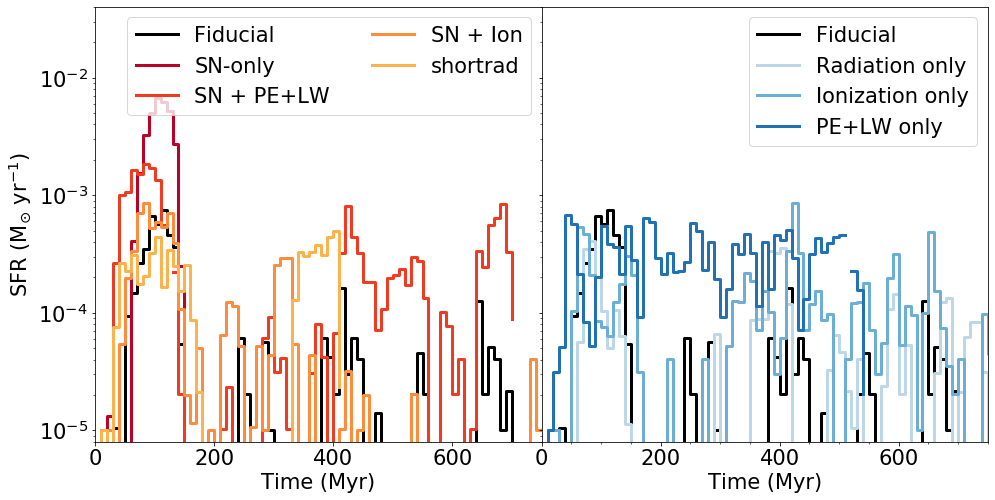

In [422]:
#
# plot a SFR comparison
#
plot_settings()

fig, axes = plt.subplots(1,2,sharey=True)
fig.set_size_inches(16,8)

fig.subplots_adjust(wspace=0)

runs_to_plot = base_comparison

ax = axes[0]
runs_to_plot = sn_runs+ misc_runs
runs_to_plot = ['fiducial','sn_only','sn_otrad_no-ion','sn_ion-no-otrad','shortrad']
#runs_to_plot = ['fiducial']

for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
    SFR = all_data[run].load_single('/time_data/SFR',index = -1)
    
   # print(np.shape(t),np.shape(SFR[:-1])) 
    new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

    t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, 10.0, method='average')    
    if run == 'fiducial':
        color = 'black'
    else:
        color = "C%0i"%(i)    
    ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = colors[run], ls=lstyles[run])
    #ax.plot(t[:-1], SFR, label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    plt.minorticks_on()


ax = axes[1]
runs_to_plot =  ['fiducial'] + no_sn_runs 
#runs_to_plot = ['fiducial'] + ['otrad_no-ion-sn','ion_no-otrad-sn']
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
    SFR = all_data[run].load_single('/time_data/SFR',index = -1)
    
   # print(np.shape(t),np.shape(SFR[:-1])) 
    new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

    #SFR[SFR<1.0E-6]=
    
    t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, 10.0, method='average')    
    if run == 'fiducial':
        color = 'black'
    else:
        color = "C%0i"%(i)    
    ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = colors[run], ls=lstyles[run])
    #ax.plot(t[:-1], SFR, label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
   
    plt.minorticks_on()
    
for ax in axes:
    ax.set_xlabel(r'Time (Myr)')
    ax.semilogy()
    ax.set_xlim(global_time_lim)
    ax.set_ylim(8.0E-6,4.0E-2)
axes[0].legend(ncol = 2,loc = 'upper right')
axes[1].legend(loc='best',ncol = 1)
axes[0].set_ylabel(r'SFR (M$_{\odot}$ yr$^{-1}$)')



#ax.set_ylim()
fig.savefig('./physics_comparison/physics_comparison_sfr_sn4_ion3.png')

0.10797193610285677
0.46988158641896705
0.10797193610285677
0.46988158641896705


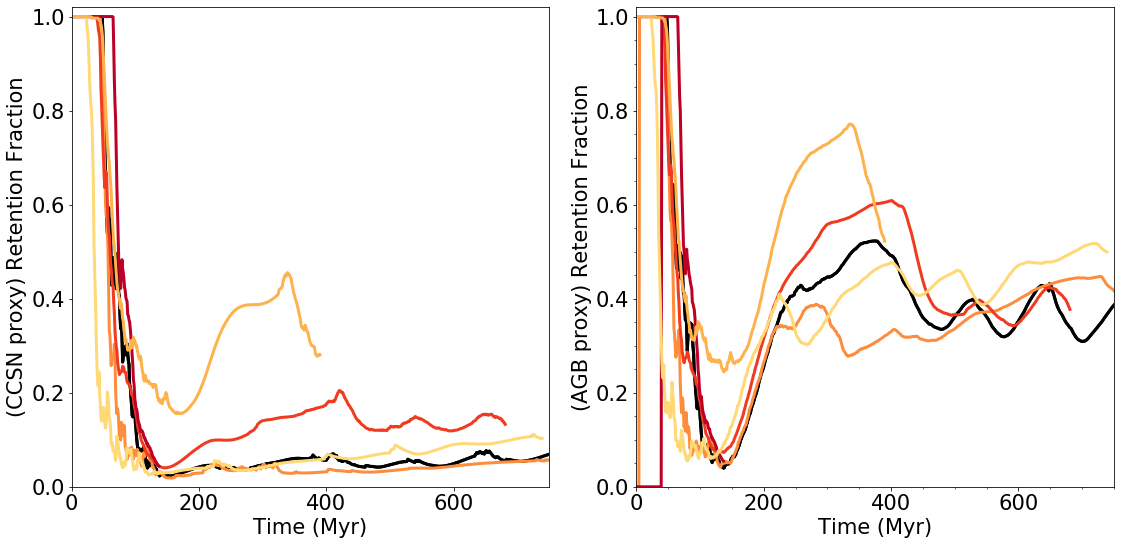

In [426]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plt.minorticks_on()


runs_to_plot = base_comparison + ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5']
runs_to_plot = ['fiducial'] + sn_runs + misc_runs
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/O')
    ax[0].plot(t, ( M_disk / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])    

    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Ba')
    
    #M_disk[t < 150] = None
    
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])
    
    ax[1].plot(t, (M_disk / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(global_time_lim)
    a.set_ylim(0, 1.02) #   'shortrad',
ax[0].set_ylabel(r'(CCSN proxy) Retention Fraction')
ax[1].set_ylabel(r'(AGB proxy) Retention Fraction')

#ax.semilogy()

#ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison/physics_comparison_retention_2.png")

0.08510441433563853
0.46988158641896705
-1.789745246901477


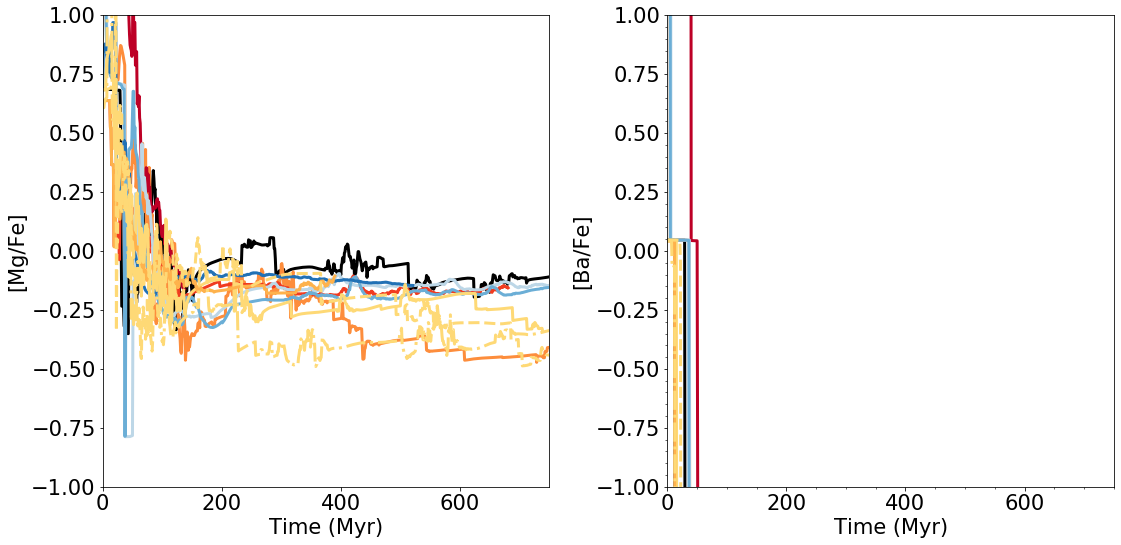

In [447]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plt.minorticks_on()


runs_to_plot = base_comparison + ['sn_otrad_ion_RPx2','sn_otrad_ion_RPx5']
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Mg') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Mg')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Mg')
    M_disk2 = all_data[run].load_field('/gas_meta_data/masses/Disk/Fe')
    
    aratio = convert_abundances.abundance_ratio_array('Mg',M_disk,'Fe',M_disk2,'mass')
    
    ax[0].plot(t, aratio,
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])    

    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Ba')
    M_disk2 = all_data[run].load_field('/gas_meta_data/masses/Disk/Fe')
    
    aratio = convert_abundances.abundance_ratio_array('Ba',M_disk,'Fe',M_disk2,'mass')
    #M_disk[t < 150] = None
    
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])
    
    ax[1].plot(t, aratio,
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(global_time_lim)
    a.set_ylim(-1, 1) #   'shortrad',
ax[0].set_ylabel(r'[Mg/Fe]')
ax[1].set_ylabel(r'[Ba/Fe]')

#ax.semilogy()

M_disk = all_data['fiducial'].load_field('/gas_meta_data/masses/FullBox/Mg')+all_data['fiducial'].load_field('/gas_meta_data/masses/OutsideBox/Mg')
M_disk2 = np.ones(np.size(M_disk))*all_data['fiducial'].load_field('/gas_meta_data/masses/Disk/H')[0]
    
aratio = convert_abundances.abundance_ratio_array('Mg',M_disk,'H',M_disk2,'mass')
t   = all_data['fiducial'].data('time')
t = t - t[0]   
print(np.max(aratio))
#ax[0].plot(t, aratio, ls = '--',
#            lw = 5, color = 'black')

#ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison_gas_abundance.png")

In [427]:
temp = all_data['fiducial'].load_field('/gas_meta_data/masses/Disk/')

In [434]:
convert_abundances.abundance_ratio_array?